# 🏢 Projet 3 : Project Lead Douglas Prédiction de la Consommation Énergétique et des Émissions CO2

## 🎯 Objectifs du Projet

Ce projet vise à construire **deux modèles de régression supervisée** pour prédire :

1. **La consommation énergétique** (`SiteEnergyUse(kBtu)`) des bâtiments non-résidentiels de Seattle
2. **Les émissions de CO2** (`TotalGHGEmissions`) associées à ces bâtiments

**Contexte :** Dataset "2016 Building Energy Benchmarking" de la ville de Seattle (3376 bâtiments initiaux).

**Méthodologie :** Analyse exploratoire → Feature Engineering → Modélisation → Optimisation → Interprétation

---

# 📊 PARTIE 0 : Analyse Exploratoire


### Import des modules


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

### Analyse Exploratoire


In [2]:
# Charger le dataset
df = pd.read_csv("data/2016_Building_Energy_Benchmarking.csv")

In [3]:
# On regarde comment les batiments sont définis dans le dataset
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [4]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [5]:
# Affiche le pourcentage de valeurs manquantes par colonne.
print(df.isna().mean().sort_values(ascending=False))

Comments                           1.000000
Outlier                            0.990521
YearsENERGYSTARCertified           0.964751
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ENERGYSTARScore                    0.249704
LargestPropertyUseTypeGFA          0.005924
LargestPropertyUseType             0.005924
ZipCode                            0.004739
ListOfAllPropertyUseTypes          0.002666
Electricity(kWh)                   0.002666
SourceEUIWN(kBtu/sf)               0.002666
GHGEmissionsIntensity              0.002666
TotalGHGEmissions                  0.002666
NaturalGas(therms)                 0.002666
SteamUse(kBtu)                     0.002666
NaturalGas(kBtu)                   0.002666
SourceEUI(kBtu/sf)                 0.002666
Electricity(kBtu)                  0.002666
NumberofBuildings                  0.002370
SiteEUI(kBtu/sf)                

#### 📖 Compréhension des colonnes principales

**Variables cibles potentielles (consommation énergétique) :**

- `SiteEnergyUse(kBtu)` : Consommation totale d'énergie sur site
- `TotalGHGEmissions` : Émissions totales de gaz à effet de serre

| Type de Feature  | Question posée         | Rôle                                                      | Impact sur la Prédiction                                                                                           |
| :--------------- | :--------------------- | :-------------------------------------------------------- | :----------------------------------------------------------------------------------------------------------------- |
| **Identitaire**  | _C'est qui ?_          | Sert à identifier, filtrer ou grouper les données.        | **Faible**<br>Le nom du bâtiment ne change pas sa physique.                                                        |
| **Structurelle** | _C'est fait comment ?_ | Caractéristiques physiques immuables (Le Contenant).      | **Physique**<br>Détermine la consommation de base (Plus c'est grand/vieux, plus ça consomme).                      |
| **Usage**        | _On y fait quoi ?_     | Le comportement et l'activité à l'intérieur (Le Contenu). | **Intensité**<br>Variable critique : explique pourquoi un Hôpital consomme 10x plus qu'un Entrepôt de même taille. |

**Features identitaires :**

- `PropertyName` : Nom du bâtiment (identification)
- `BuildingType` : Type de bâtiment (résidentiel/non-résidentiel) → **Filtre principal**
- `PrimaryPropertyType` : Catégorie détaillée (Office, School, Warehouse, etc.)

**Features structurelles :**

- `PropertyGFATotal` : Surface totale en pieds carrés (crucial pour normalisation)
- `YearBuilt` : Année de construction (âge du bâtiment)
- `NumberofBuildings` : Nombre de bâtiments dans la propriété

**Features d'usage :**

- `LargestPropertyUseType` : Usage principal du bâtiment
- `SecondLargestPropertyUseType` : Usage secondaire (si présent)
- `LargestPropertyUseTypeGFA` : Surface dédiée à l'usage principal

**Stratégie de nettoyage :**

1. Garder les colonnes avec **<50% de valeurs manquantes** ET pertinentes pour la modélisation
2. Supprimer les colonnes **constantes** (ou redondante)
3. Éliminer les lignes avec **valeurs manquantes sur les targets**
4. Détecter et retirer les **incohérences métier** (surface/énergie négatives ou nulles)


In [6]:
# Préparations des chiffres
n_total = df.shape[0]
nb_habitations = df["BuildingType"].str.contains("Multifamily").sum()

# On calcule le pourcentage dans une variable à part
pct_habitations = nb_habitations / n_total

print(f"Nombre initial de bâtiments : {n_total}")
print(
    f"   - Dont habitations (Hors périmètre) : {nb_habitations} ({pct_habitations:.1%})"  # Arrondir et faire x100 + le symbole "%"
)

# Filtre qui permet de ne garder que les bâtiments non résidentiels
df = df[~df["BuildingType"].str.contains("Multifamily")]  # (~ = NOT)
n_after_filter = df.shape[0]

print(f"Nombre de bâtiments après filtre 'Non-Res' : {n_after_filter}")


# Liste des colonnes identifiées comme inutilisables (>50% vide ou hors sujet => risque de bruit)
cols_to_drop = [
    "Comments",
    "Outlier",
    "YearsENERGYSTARCertified",
]


# Nettoyage structurel du dataset
df = df.drop(columns=cols_to_drop, errors="ignore")

# Suppression des rows où les cibles sont vides (0 vide dans notre cas donc parfait)
targets = ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]
df = df.dropna(subset=targets)

# Vérification  de la taille
print(
    f"Taille du dataset après nettoyage structurel : {df.shape}"  # (Nombre de lignes et colonnes )
)

Nombre initial de bâtiments : 3376
   - Dont habitations (Hors périmètre) : 1708 (50.6%)
Nombre de bâtiments après filtre 'Non-Res' : 1668
Taille du dataset après nettoyage structurel : (1666, 43)


In [7]:
# NETTOYAGE DES COLONNES

# Les colonnes qui n'ont qu'une seule valeur unique
const_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f"Colonnes constantes supprimées : {const_cols}")
df = df.drop(columns=const_cols)

# DOUBLONS
duplicates_count = df.duplicated().sum()
print(f"Nombre de doublons trouvés : {duplicates_count}")

# Si doublons on supprime pour garder qu'une seule version unique
if duplicates_count > 0:
    df = df.drop_duplicates()
    print("Doublons supprimés.")

# INCOHÉRENCES
# Garder que les valeurs positives
nb_incoherent = len(
    df[(df["PropertyGFATotal"] <= 0) | (df["SiteEnergyUse(kBtu)"] <= 0)]
)
if nb_incoherent > 0:
    print(
        f"\nSuppression de {nb_incoherent} bâtiments incohérents (Surface ou Energie <= 0)."
    )
    df = df[df["PropertyGFATotal"] > 0]
    df = df[df["SiteEnergyUse(kBtu)"] > 0]


# GESTION DES NaN POUR VARIABLES D'USAGE
# NaN dans Third* = "pas de 3ème usage" → Information utile, pas une erreurprint(f"\n---> Dataset prêt pour la suite : {df.shape}")

df["ThirdLargestPropertyUseType"] = df["ThirdLargestPropertyUseType"].fillna("None")
df["ThirdLargestPropertyUseTypeGFA"] = df["ThirdLargestPropertyUseTypeGFA"].fillna(0)
print("   ThirdLargestPropertyUseType : NaN → 'None' (absence de 3ème usage)")
print("   ThirdLargestPropertyUseTypeGFA : NaN → 0")

Colonnes constantes supprimées : ['DataYear', 'City', 'State']
Nombre de doublons trouvés : 0

Suppression de 16 bâtiments incohérents (Surface ou Energie <= 0).
   ThirdLargestPropertyUseType : NaN → 'None' (absence de 3ème usage)
   ThirdLargestPropertyUseTypeGFA : NaN → 0


### Analyse Statistique Descriptive

| Indicateur Statistique | Définition Simple                                                 | Interprétation pour le Projet (Seattle)                                                                                                  |
| :--------------------- | :---------------------------------------------------------------- | :--------------------------------------------------------------------------------------------------------------------------------------- |
| **Moyenne** (`mean`)   | Le centre de gravité mathématique.                                | **Tendance globale**, mais fortement tirée vers le haut par les quelques bâtiments géants (Campus, Hôpitaux).                            |
| **Médiane** (`median`) | La valeur centrale (50% au-dessus, 50% en dessous).               | **Le bâtiment "Standard"**. C'est la valeur la plus représentative de la réalité de la majorité du parc immobilier.                      |
| **Écart-type** (`std`) | La dispersion des valeurs autour de la moyenne.                   | **La diversité**. Un écart-type élevé indique que le parc est très hétérogène (mélange de petits commerces et de grands buildings).      |
| **Outliers** (`3σ`)    | Valeurs dépassant le seuil statistique (Moyenne + 3x Écart-type). | **Les anomalies ou géants**. Ce sont les cas extrêmes (structures très énergivores) qu'il faudra peut-être traiter à part ou surveiller. |


In [8]:
# Statistiques sur la consommation d'énergie
print("\n🔋 CONSOMMATION D'ÉNERGIE (kBtu)")
print(f"   Moyenne : {df['SiteEnergyUse(kBtu)'].mean():,.0f} kBtu")
print(f"   Médiane : {df['SiteEnergyUse(kBtu)'].median():,.0f} kBtu")
print(f"   Écart-type : {df['SiteEnergyUse(kBtu)'].std():,.0f} kBtu")
print(f"   Min : {df['SiteEnergyUse(kBtu)'].min():,.0f} kBtu")
print(f"   Max : {df['SiteEnergyUse(kBtu)'].max():,.0f} kBtu")

# Statistiques sur les émissions CO2
print("\n🌍 ÉMISSIONS DE CO2 (Metric Tons)")
print(f"   Moyenne : {df['TotalGHGEmissions'].mean():,.0f} tons")
print(f"   Médiane : {df['TotalGHGEmissions'].median():,.0f} tons")
print(f"   Écart-type : {df['TotalGHGEmissions'].std():,.0f} tons")
print(f"   Min : {df['TotalGHGEmissions'].min():,.0f} tons")
print(f"   Max : {df['TotalGHGEmissions'].max():,.0f} tons")

# Détection des outliers
energy_mean = df["SiteEnergyUse(kBtu)"].mean()
energy_std = df["SiteEnergyUse(kBtu)"].std()
outliers_energy = df[df["SiteEnergyUse(kBtu)"] > energy_mean + 3 * energy_std]

print("\nOUTLIERS DÉTECTÉS :")
print(
    f"Bâtiments avec consommation > 3σ : {len(outliers_energy)} ({len(outliers_energy) / len(df) * 100:.1f}%)"
    # 3σ (Sigma) = 3 fois l'écart-type : c'est la frontière statistique au-delà de laquelle une valeur est considérée comme une anomalie (Outlier).
)
print(
    f"Seuil outlier : {energy_mean + 3 * energy_std:,.0f} kBtu"
)  # on détermine ce seuil en fonction de la distribution des données(moyenne et écart-type).


🔋 CONSOMMATION D'ÉNERGIE (kBtu)
   Moyenne : 8,519,756 kBtu
   Médiane : 2,593,203 kBtu
   Écart-type : 30,378,696 kBtu
   Min : 16,809 kBtu
   Max : 873,923,712 kBtu

🌍 ÉMISSIONS DE CO2 (Metric Tons)
   Moyenne : 186 tons
   Médiane : 50 tons
   Écart-type : 755 tons
   Min : -1 tons
   Max : 16,871 tons

OUTLIERS DÉTECTÉS :
Bâtiments avec consommation > 3σ : 11 (0.7%)
Seuil outlier : 99,655,845 kBtu


#### 📊 Graphiques 1 & 2 : Classement Énergétique et Écologique par Type de Bâtiment

**Objectif :** Comparer les 22 types de bâtiments pour identifier les catégories les plus consommatrices et polluantes.

**Méthodologie technique :**

- **Visualisation** : Boxplots (boîtes à moustaches) pour visualiser médiane, quartiles et outliers
- **Tri intelligent** : Classement automatique par médiane croissante (les plus économes à gauche, les plus gourmands à droite)
- **Échelle logarithmique** : Permet de comparer sur un même graphique les entrepôts (~100k kBtu) et les hôpitaux (~100M kBtu)
- **Dataset complet** : Analyse sur les 1650 bâtiments (tous types confondus)

**Graphique 1 : Classement de la Consommation d'Énergie**

- Lecture immédiate des types les plus énergivores (positionnés à droite)
- Hauteur de chaque boîte = variabilité au sein d'une catégorie
- Points isolés = outliers (bâtiments atypiques)

**Graphique 2 : Classement des Émissions de CO2**

- Même méthodologie appliquée aux émissions de gaz à effet de serre
- Permet de vérifier la corrélation entre consommation énergétique et pollution
- Confirme que les types les plus énergivores sont généralement les plus pollueurs


In [9]:
# Consommation d'Énergie
fig_energy = px.box(
    df,
    x="PrimaryPropertyType",
    y="SiteEnergyUse(kBtu)",
    color="PrimaryPropertyType",
    title="Classement de la consommation par type de bâtiment",
    log_y=True,
    points="outliers",
    hover_data=["PropertyName"],
)

# On trie l'axe X par ordre croissant de consommation (médiane)
# Permet de voir immédiatement qui sont les "mauvais élèves" à droite
fig_energy.update_xaxes(categoryorder="median ascending")

# On cache la légende qui prend trop de place
fig_energy.update_layout(showlegend=False)

fig_energy.show()

# Émissions de CO2
fig_co2 = px.box(
    df,
    x="PrimaryPropertyType",
    y="TotalGHGEmissions",
    color="PrimaryPropertyType",
    title="Classement des émissions de CO2 par type de bâtiment",
    log_y=True,
    points="outliers",
    hover_data=["PropertyName"],
)

# On trie par pollution médiane ( les plus pollueurs à droite (mauvais élèves) )
fig_co2.update_xaxes(categoryorder="median ascending")
fig_co2.update_layout(showlegend=False)

fig_co2.show()

#### 📊 Graphique 3 : Relation Surface vs Consommation (Vue Globale)

**🎯 Objectif :** Vérifier la corrélation entre la surface et la consommation sur l'ensemble du parc immobilier, et observer la relation avec les émissions CO2.

**Ce qu'on observe :**

- **Corrélation forte (Ligne Rouge) :** La ligne de tendance (Régression OLS) confirme mathématiquement que la consommation augmente avec la surface. L'hypothèse est validée.
- **Échelle Logarithmique :** Indispensable pour visualiser lisiblement les petits bâtiments (10k ft²) et les campus géants (5M+ ft²) sur le même plan.
- **Indicateur CO2 (Couleur des points) :** La couleur indique le niveau d'émissions de gaz à effet de serre. On confirme que les bâtiments les plus consommateurs sont aussi les plus pollueurs (corrélation +0.860).

**Points d'attention (Analyse des Outliers) :**

- **La "Normalité" :** La grande majorité des points se concentrent autour de la ligne rouge. C'est le comportement attendu.
- **Les Anomalies (Outliers) :**
  - **Au-dessus de la ligne rouge :** Bâtiments énergivores. Pour une même surface, ils consomment beaucoup plus que la moyenne (ex: Laboratoires, Supermarchés, ou mauvaise isolation).
  - **En-dessous de la ligne rouge :** Bâtiments économes ou à faible occupation (ex: Entrepôts, Lieux de culte).

**💡 Conclusion :** La surface est le facteur déterminant principal pour les deux targets (énergie ET CO2), mais les écarts importants autour de la ligne de tendance montrent que le _Type d'usage_ jouera un rôle clé pour affiner les prédictions.


In [10]:
fig_scatter = px.scatter(
    df,
    x="PropertyGFATotal",
    y="SiteEnergyUse(kBtu)",
    color="TotalGHGEmissions",
    opacity=0.5,
    log_x=True,
    log_y=True,
    title="Corrélation Globale : Surface vs Consommation (+ Tendance)",
    trendline="ols",  # Ajout de la ligne de régression
    trendline_color_override="red",
    hover_data=["PropertyName", "PrimaryPropertyType"],
)

fig_scatter.show()

#### 📊 Graphique 4 : Matrice de Corrélation (Heatmap)

**🎯 Objectif :** Visualiser d'un seul coup d'œil toutes les relations entre les variables numériques clés du dataset.

**Méthodologie :**

- **Variables sélectionnées** : Cibles énergétiques, caractéristiques structurelles et performances
- **Coefficient de Pearson** : Mesure la force et le sens de la relation linéaire entre deux variables (-1 à +1)
- **Lecture de la Heatmap** :
  - **Rouge foncé (proche de +1)** : Corrélation positive forte (quand l'une augmente, l'autre aussi)
  - **Bleu foncé (proche de -1)** : Corrélation négative forte (relation inverse)
  - **Blanc (proche de 0)** : Pas de corrélation linéaire

**Ce qu'on cherche :**

1. **Variables fortement corrélées aux cibles** (`SiteEnergyUse(kBtu)` ET `TotalGHGEmissions`) → Features prédictives puissantes
2. **Redondances** : Variables très corrélées entre elles → Risque de multicolinéarité (à éviter en modélisation)
3. **Relations inattendues** : Découvertes de patterns non évidents
4. **Comparaison des deux targets** : Identifier si les mêmes features prédisent l'énergie ET les émissions CO2

**💡 Utilité pour la Modélisation :**

- Sélectionner les features les plus pertinentes pour **chaque target** (Énergie ET CO2)
- Éviter d'inclure des variables redondantes qui n'apportent pas d'information supplémentaire
- Comprendre les mécanismes physiques sous-jacents (ex: Surface → Énergie → CO2)
- **Comparer les profils prédictifs** des deux targets pour adapter la stratégie de modélisation
- Valider que les deux targets ont suffisamment de corrélations avec les features disponibles


In [11]:
# Sélection des variables numériques pertinentes
# On garde les variables structurelles, énergétiques et d'usage
corr_cols = [
    "SiteEnergyUse(kBtu)",  # TARGET 1 : Consommation totale
    "TotalGHGEmissions",  # TARGET 2 : Émissions CO2
    "PropertyGFATotal",  # Surface totale (facteur principal)
    "YearBuilt",  # Âge du bâtiment (isolation, efficacité)
    "NumberofFloors",  # Hauteur (peut influencer chauffage/clim)
    "NumberofBuildings",  # Nombre de bâtiments dans le complexe
    "LargestPropertyUseTypeGFA",  # Surface du plus grand usage
    "SecondLargestPropertyUseTypeGFA",  # Surface du 2ème plus grand usage
    "ThirdLargestPropertyUseTypeGFA",  # Surface du 3ème plus grand usage
]

# Calcul de la matrice de corrélation (Pearson)
corr_matrix = df[corr_cols].corr()

fig_corr = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale="RdBu_r",
        zmid=0,  # Centre de l'échelle à 0
        text=corr_matrix.values.round(2),  # Afficher les valeurs
        texttemplate="%{text}",
        textfont={"size": 10},
        colorbar=dict(title="Corrélation"),
    )
)

fig_corr.update_layout(
    title="Matrice de Corrélation des Variables Clés",
    xaxis_title="",
    yaxis_title="",
    width=900,
    height=800,
    xaxis=dict(tickangle=-45),  # Inclinaison des labels
)

fig_corr.show()


print("\n CORRÉLATIONS AVEC LES DEUX TARGETS POTENTIELLES :\n")

# Target 1 : Consommation d'énergie
print("⚡ TARGET 1 : SiteEnergyUse(kBtu) - Consommation énergétique")
target1_corr = corr_matrix["SiteEnergyUse(kBtu)"].sort_values(ascending=False)
for var, corr_value in target1_corr.items():
    if var != "SiteEnergyUse(kBtu)":  # Exclure la cible elle-même car toujours à 1.0
        print(f"   {var:30} : {corr_value:+.3f}")

# Target 2 : Émissions CO2
print("\n TARGET 2 : TotalGHGEmissions - Émissions de CO2")
target2_corr = corr_matrix["TotalGHGEmissions"].sort_values(ascending=False)
for var, corr_value in target2_corr.items():
    if var != "TotalGHGEmissions":
        print(f"   {var:30} : {corr_value:+.3f}")

print(
    "\n ANALYSE : Les deux targets sont fortement corrélées (+0.860), donc les mêmes features seront pertinentes."
)
print(
    "    Choix final : SiteEnergyUse(kBtu) et TotalGHGEmissions car 0% de valeurs manquantes."
)



 CORRÉLATIONS AVEC LES DEUX TARGETS POTENTIELLES :

⚡ TARGET 1 : SiteEnergyUse(kBtu) - Consommation énergétique
   TotalGHGEmissions              : +0.860
   LargestPropertyUseTypeGFA      : +0.846
   PropertyGFATotal               : +0.809
   NumberofBuildings              : +0.713
   SecondLargestPropertyUseTypeGFA : +0.671
   ThirdLargestPropertyUseTypeGFA : +0.330
   NumberofFloors                 : +0.219
   YearBuilt                      : +0.064

 TARGET 2 : TotalGHGEmissions - Émissions de CO2
   SiteEnergyUse(kBtu)            : +0.860
   LargestPropertyUseTypeGFA      : +0.575
   SecondLargestPropertyUseTypeGFA : +0.539
   PropertyGFATotal               : +0.528
   NumberofBuildings              : +0.418
   ThirdLargestPropertyUseTypeGFA : +0.387
   NumberofFloors                 : +0.130
   YearBuilt                      : +0.051

 ANALYSE : Les deux targets sont fortement corrélées (+0.860), donc les mêmes features seront pertinentes.
    Choix final : SiteEnergyUse(kBtu) e

### 📋 Synthèse de l'Analyse Exploratoire

#### Nettoyage et Préparation des Données

**1. Restriction au périmètre pertinent :**

- **Exclus** : 1708 bâtiments "Multifamily" (habitations hors périmètre).
- **Conservés** : 1650 bâtiments non-résidentiels (après suppression des valeurs négatives/nulles).

**2. Colonnes supprimées (arguments métier) :**

- **>50% vide** : `Comments`, `YearsENERGYSTARCertified` → Trop peu d'information exploitable.
- **Constantes** : `DataYear`, `City`, `State` → Aucun pouvoir discriminant (variance nulle).
- **Hors cible** : `Outlier` → Gestion manuelle des outliers préférée.
- **⚠️ Exception** : `ThirdLargestPropertyUseType` (50% NaN) **conservée** → NaN = "pas de 3ème usage" = information utile.

**3. Lignes supprimées :**

- **16 bâtiments** avec Surface ≤ 0 ou Énergie ≤ 0 (incohérence métier).
- **1 bâtiment** avec émissions CO2 négatives (impossible physiquement).

**4. Dataset final :**

- **1649 bâtiments** × **40 colonnes** (après nettoyage complet).
- **Targets choisies** :
  - `SiteEnergyUse(kBtu)` - Consommation énergétique
  - `TotalGHGEmissions` - Émissions de CO2
  - Raison : 0% de valeurs manquantes pour les deux, forte corrélation (+0.860) validant leur cohérence.
- **Variables d'usage conservées** : Largest, Second, Third (complexité du bâtiment → prédictif)

---

#### Insights Clés

**1. Distribution des consommations :**

- **Forte asymétrie à droite** (Moyenne >> Médiane).
- Moyenne : ~8.4M kBtu | Médiane : ~2.5M kBtu.
- **Conséquence** : Une transformation logarithmique de la target sera indispensable pour la modélisation.

**2. Influence du Type de Bâtiment (Usage) :**

- Le **PrimaryPropertyType** est un facteur discriminant majeur.
- **Gros consommateurs** : Hôpitaux, Supermarchés, Data Centers.
- **Faibles consommateurs** : Entrepôts, Lieux de culte.

**3. Analyse de Corrélation (9 variables numériques clés) :**

Nous avons écarté les variables de consommation (Élec/Gaz) pour éviter le data leakage. Voici les vrais moteurs physiques :

**Pour Target 1 (Consommation Énergétique) :**

- **`LargestPropertyUseTypeGFA` (+0.846)** : La surface dédiée à l'usage principal est le prédicteur le plus fort. C'est la combinaison surface × intensité d'usage qui explique la consommation.
- **`PropertyGFATotal` (+0.809)** : La surface totale reste un facteur majeur (relation quasi-linéaire sur échelle log).
- **`NumberofBuildings` (+0.713)** : La complexité du site (Campus, Hôpitaux multi-bâtiments) est un indicateur très fort.
- **`SecondLargestPropertyUseTypeGFA` (+0.671)** : Le 2ème usage contribue également à la diversité énergétique.
- **`ThirdLargestPropertyUseTypeGFA` (+0.330)** : La présence d'un 3ème usage distinct indique une complexité fonctionnelle (ex: hôpital avec data center).
- **`NumberofFloors` (+0.219)** : La hauteur joue un rôle secondaire.
- **`YearBuilt` (+0.064)** : Pas de corrélation linéaire directe. L'âge joue un rôle complexe (non-linéaire) qui nécessitera des modèles adaptés (arbres de décision).

**Pour Target 2 (Émissions CO2) :**

- **`SiteEnergyUse(kBtu)` (+0.860)** : Corrélation très forte avec l'énergie (logique physique : plus d'énergie = plus d'émissions).
- **`LargestPropertyUseTypeGFA` (+0.575)** : L'usage principal a un impact majeur sur les émissions (certains usages émettent plus de CO2).
- **`SecondLargestPropertyUseTypeGFA` (+0.539)** : La diversité d'usage contribue significativement aux émissions.
- **`PropertyGFATotal` (+0.528)** : La surface totale a moins d'impact direct sur les émissions que sur l'énergie (le type d'énergie utilisée compte plus).
- **`NumberofBuildings` (+0.418)** : Impact modéré de la complexité du site.
- **`ThirdLargestPropertyUseTypeGFA` (+0.387)** : La complexité fonctionnelle joue un rôle pour les émissions.
- **`NumberofFloors` (+0.130)** : Corrélation faible avec les émissions.
- **`YearBuilt` (+0.051)** : Aucune corrélation linéaire directe.

**💡 Insight clé :** Les variables de **surface par type d'usage** (Largest/Second/Third GFA) sont des prédicteurs puissants car elles capturent à la fois la taille ET l'intensité énergétique de chaque fonction du bâtiment. Un hôpital de 10 000 m² consomme bien plus qu'un entrepôt de même surface.


In [12]:
# NETTOYAGE AVANT MODÉLISATION

# Supprimer les émissions négatives (physiquement impossibles)
nb_negatif = len(df[df["TotalGHGEmissions"] < 0])
if nb_negatif > 0:
    print(f"   Suppression de {nb_negatif} bâtiment(s) avec émissions négatives")
    df = df[df["TotalGHGEmissions"] >= 0]

# Vérification
print(f" Dataset final prêt pour la modélisation : {df.shape}")
print(f"   - Bâtiments : {df.shape[0]}")
print(f"   - Variables : {df.shape[1]}")

   Suppression de 1 bâtiment(s) avec émissions négatives
 Dataset final prêt pour la modélisation : (1649, 40)
   - Bâtiments : 1649
   - Variables : 40


#### ✅ Analyse Exploratoire COMPLÈTE

**Résumé des accomplissements :**

1. **Compréhension du dataset** : Explication détaillée des colonnes clés et de leur rôle
2. **Nettoyage structuré** : Suppression justifiée de colonnes/lignes avec traçabilité complète
3. **Statistiques descriptives** : Résumé des variables cibles (énergie, CO2) avec détection d'outliers
4. **Visualisations pertinentes** :
   - Boxplots comparatifs (22 types de bâtiments classés par consommation ET émissions CO2)
   - Scatter plot avec ligne de tendance OLS (corrélation Surface vs Énergie, coloré par CO2)
   - Heatmap de corrélation (relations entre variables clés + **comparaison des 2 targets**)
5. **Choix des targets justifié** :
   - **Target 1** : `SiteEnergyUse(kBtu)` - Consommation énergétique
   - **Target 2** : `TotalGHGEmissions` - Émissions de CO2
   - Raison : 0% de valeurs manquantes, forte corrélation (+0.860), profils prédictifs différents
6. **Identification des incohérences** : Valeurs négatives/nulles détectées et supprimées

**Dataset final prêt pour la modélisation : 1649 bâtiments × 40 colonnes**
**Objectif : Construire DEUX modèles de prédiction (un par target)**

---

### 📚 Ressources Complémentaires

Pour approfondir l'esprit d'une analyse exploratoire, consultez :

https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

_(Ce notebook n'est pas un modèle à suivre strictement, mais une source d'inspiration)_


# Modélisation


### Import des modules


In [13]:
# Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


### Feature Engineering


**🎯 Objectif :** Créer de nouvelles variables (features) à partir des colonnes existantes pour enrichir le pouvoir prédictif du modèle.

**⚠️ RÈGLE D'OR : Pas de Data Leakage !**

- Ne jamais utiliser des variables qui contiennent déjà la réponse (quantités d'Electricity, NaturalGas, Steam)
- Créer uniquement des features dérivées de caractéristiques **structurelles**, **d'usage** ou **géographiques**

---

**💡 Pistes de Réflexion :**

**1. Temporalité (Âge du bâtiment) :**

- `BuildingAge` : 2016 - YearBuilt
- Possibilité de créer des tranches d'âge (Ex: <10 ans, 10-30 ans, >30 ans)

**2. Structure du bâtiment :**

- `HasMultipleBuildings` : Indicateur binaire (0/1) si le site contient plusieurs bâtiments
- `FloorsPerBuilding` : Ratio NumberofFloors / NumberofBuildings (si >1 bâtiment)

**3. Multi-Usage (Proportion) :**

- `HasSecondaryUse` : Indicateur binaire si usage secondaire existe
- `SecondaryUseProportion` : SecondLargestPropertyUseTypeGFA / PropertyGFATotal (si disponible)

**4. Sources d'énergie (Présence SANS quantité) :**

- `HasElectricity` : 1 si Electricity(Kbtu) > 0, sinon 0
- `HasNaturalGas` : 1 si NaturalGas(therms) > 0, sinon 0
- `HasSteam` : 1 si SteamUse(kBtu) > 0, sinon 0
- → Ces features structurelles indiquent l'équipement disponible SANS révéler l'intensité de consommation

**5. Localisation :**

- **`DistanceToCenter`** : Distance géographique entre le bâtiment et le centre-ville de Seattle
  - Utiliser les coordonnées `Latitude` et `Longitude` du dataset
  - Centre-ville de Seattle : **Latitude 47.6062, Longitude -122.3321** (Pike Place Market)
  - Formule de distance : **Haversine** (pour calculer la distance en km entre 2 points GPS)
  - **Pourquoi c'est important ?** Les bâtiments en périphérie consomment différemment (bureaux vs zones industrielles)
- `Neighborhood` : Optionnel - Regroupement par ZipCode ou CouncilDistrictCode (haute cardinalité → créer des tranches)

---


In [14]:
from math import radians, sin, cos, sqrt, atan2

print("🛠️ Création des nouvelles features...\n")

# Feature 1 : Age du bâtiment
current_year = 2016
df["BuildingAge"] = current_year - df["YearBuilt"]
print("✅ Feature 1 : BuildingAge")
print(f"   Âge moyen : {df['BuildingAge'].mean():.1f} ans")

# Feature 2 : Indicateur site multi-bâtiments (0 ou 1)
df["HasMultipleBuildings"] = (df["NumberofBuildings"] > 1).astype(int)
print("\n✅ Feature 2 : HasMultipleBuildings")
print(
    f"   {df['HasMultipleBuildings'].sum()} sites ({df['HasMultipleBuildings'].mean():.1%})"
)

# Feature 3 : Ratio étages par bâtiment
df["FloorsPerBuilding"] = df.apply(
    lambda row: row["NumberofFloors"] / row["NumberofBuildings"]
    if row["NumberofBuildings"] > 0 and pd.notna(row["NumberofFloors"])
    else 0,
    axis=1,
)
print("\n✅ Feature 3 : FloorsPerBuilding")
print(f"   Moyenne : {df['FloorsPerBuilding'].mean():.1f} étages/bâtiment")

# Feature 4 : Indicateur usage secondaire
df["HasSecondaryUse"] = df["SecondLargestPropertyUseType"].notna().astype(int)
print("\n✅ Feature 4 : HasSecondaryUse")
print(
    f"   {df['HasSecondaryUse'].sum()} bâtiments ({df['HasSecondaryUse'].mean():.1%})"
)


# Feature 5 : Distance au centre-ville (Haversine, formule universelle de distance entre 2 points GPS sur une sphère)
def haversine(lat1, lon1, lat2, lon2):
    """Calcule la distance en km entre deux points GPS"""
    R = 6371  # Rayon de la Terre en km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = (
        sin(dlat / 2) ** 2
        + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    )
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


center_lat, center_lon = 47.6062, -122.3321  # Pike Place Market, Seattle
df["DistanceToCenter"] = df.apply(
    lambda row: haversine(row["Latitude"], row["Longitude"], center_lat, center_lon)
    if pd.notna(row["Latitude"]) and pd.notna(row["Longitude"])
    else 0,
    axis=1,
)
print("\n✅ Feature 5 : DistanceToCenter")
print(f"   Distance moyenne : {df['DistanceToCenter'].mean():.2f} km")
print(f"   Distance max : {df['DistanceToCenter'].max():.2f} km")

# Features 6-8 : Indicateurs sources d'énergie (présence SANS quantité)

# Remplace NaN par 0 avant comparaison et conversion en int
df["HasElectricity"] = (df["Electricity(kBtu)"].fillna(0) > 0).astype(int)
df["HasNaturalGas"] = (df["NaturalGas(therms)"].fillna(0) > 0).astype(int)
df["HasSteam"] = (df["SteamUse(kBtu)"].fillna(0) > 0).astype(int)

print("\n✅ Features 6-8 : Indicateurs sources d'énergie")
print(
    f"   Électricité : {df['HasElectricity'].sum()} ({df['HasElectricity'].mean():.1%})"
)
print(
    f"   Gaz Naturel : {df['HasNaturalGas'].sum()} ({df['HasNaturalGas'].mean():.1%})"
)
print(f"   Vapeur      : {df['HasSteam'].sum()} ({df['HasSteam'].mean():.1%})")

# Feature 9 : Interaction Surface × Gaz Naturel
# Hypothèse : Les grands bâtiments avec gaz consomment/émettent différemment
df["SurfaceGasInteraction"] = df["PropertyGFATotal"] * df["HasNaturalGas"]
print("\n✅ Feature 9 : SurfaceGasInteraction")
print("   Interaction Surface × Gaz (utile pour prédire CO2)")

# Feature 10 : Ratio Énergie par Surface

# Créer une nouvelle feature "EnergyPerSurface" qui est le ratio entre la consommation d'énergie et la surface totale du bâtiment.
# Attention au risque de data leakage avec Target 1.
df["EnergyPerSurface"] = df.apply(
    lambda row: row["SiteEnergyUse(kBtu)"] / row["PropertyGFATotal"]
    if row["PropertyGFATotal"] > 0
    else 0,
    axis=1,
)
print("\n✅ Feature 10 : EnergyPerSurface")
print(f"   Ratio moyen : {df['EnergyPerSurface'].mean():.2f} kBtu/sqft")
print("   ⚠️ ATTENTION : Cette feature sera EXCLUE pour Target 1 (data leakage)")
print("   ✅ Utilisable pour Target 2 (CO2) si Target 1 exclue")

print("\n🎉 Feature Engineering terminé ! 10 nouvelles features créées")
print(f"   Taille du dataset : {df.shape}")

🛠️ Création des nouvelles features...

✅ Feature 1 : BuildingAge
   Âge moyen : 54.2 ans

✅ Feature 2 : HasMultipleBuildings
   53 sites (3.2%)

✅ Feature 3 : FloorsPerBuilding
   Moyenne : 4.0 étages/bâtiment

✅ Feature 4 : HasSecondaryUse
   854 bâtiments (51.8%)

✅ Feature 5 : DistanceToCenter
   Distance moyenne : 4.52 km
   Distance max : 14.24 km

✅ Features 6-8 : Indicateurs sources d'énergie
   Électricité : 1647 (99.9%)
   Gaz Naturel : 1185 (71.9%)
   Vapeur      : 114 (6.9%)

✅ Feature 9 : SurfaceGasInteraction
   Interaction Surface × Gaz (utile pour prédire CO2)

✅ Feature 10 : EnergyPerSurface
   Ratio moyen : 68.62 kBtu/sqft
   ⚠️ ATTENTION : Cette feature sera EXCLUE pour Target 1 (data leakage)
   ✅ Utilisable pour Target 2 (CO2) si Target 1 exclue

🎉 Feature Engineering terminé ! 10 nouvelles features créées
   Taille du dataset : (1649, 50)


**Objectif :** Préparer le dataset final pour l'entraînement des modèles de Machine Learning.

Cette section va structurer les données en :

- **X** : DataFrame des features (variables explicatives)
- **y** : Series de la target (variable à prédire)

**Organisation en 4 étapes :**


---

## 🎯 PARTIE 1 : PRÉDICTION DE LA CONSOMMATION ÉNERGÉTIQUE

**Target :** `SiteEnergyUse(kBtu)` - Consommation totale d'énergie du bâtiment

**Stratégie :** Nous allons exclure `TotalGHGEmissions` (Target 2) des features pour éviter le data leakage.

---


#### Étape 1 : Sélection des Features et de la Target

**À faire maintenant :**

- Sélectionner les colonnes pour **X** (features) en excluant :
  - La target 1 (`SiteEnergyUse(kBtu)`)
  - La target 2 (`TotalGHGEmissions`) → Pour éviter le data leakage
  - Les colonnes identitaires inutiles (`PropertyName`, `OSEBuildingID`, etc.)
  - Les variables de leakage (`Electricity(kBtu)`, `NaturalGas(kBtu)`, etc.)
- Extraire la target **y_energy** : `SiteEnergyUse(kBtu)`


In [15]:
print("📋 Étape 1 : Sélection des features et de la target\n")

# Liste des colonnes à supprimer (data leakage + identifiants inutiles)
leakage_cols = [
    # Variables de leakage (composants directs de la target)
    "SiteEnergyUseWN(kBtu)",  # Target normalisée météo
    "SiteEUI(kBtu/sf)",  # Target / Surface = TRICHE
    "SiteEUIWN(kBtu/sf)",
    "SourceEUI(kBtu/sf)",
    "SourceEUIWN(kBtu/sf)",
    "Electricity(kWh)",  # Composant de la target
    "Electricity(kBtu)",  # Composant de la target
    "NaturalGas(therms)",  # Composant de la target
    "NaturalGas(kBtu)",  # Composant de la target
    "SteamUse(kBtu)",  # Composant de la target
    "GHGEmissionsIntensity",
]

# Colonnes identitaires ou remplacées par des features
useless_cols = [
    "OSEBuildingID",
    "PropertyName",
    "TaxParcelIdentificationNumber",
    "Address",
    "ZipCode",  # Remplacé par DistanceToCenter
    "CouncilDistrictCode",
    "Neighborhood",  # Remplacé par DistanceToCenter
    "Latitude",  # Remplacé par DistanceToCenter
    "Longitude",  # Remplacé par DistanceToCenter
    "YearBuilt",  # Remplacé par BuildingAge
    "ComplianceStatus",
    "DefaultData",
    "ListOfAllPropertyUseTypes",
]

# Colonnes spécifiques à gérer
special_cols = [
    "ENERGYSTARScore",  # Trop de valeurs manquantes (>30%)
]

# Fusion des listes
cols_to_drop = leakage_cols + useless_cols + special_cols

# Suppression sécurisée (uniquement ce qui existe)
existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_clean = df.drop(columns=existing_cols_to_drop)

print(f"🗑️  Colonnes supprimées : {len(existing_cols_to_drop)}")
print(f"✅ Colonnes restantes  : {df_clean.shape[1]}")

# Extraction de la target 1 : Consommation d'énergie
# IMPORTANT : On exclut TotalGHGEmissions (Target 2) ET EnergyPerSurface (data leakage)
y_energy = df_clean["SiteEnergyUse(kBtu)"].copy()

# Exclusion : Target 2 + feature calculée à partir de Target 1
cols_to_exclude = ["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "EnergyPerSurface"]
X = df_clean.drop(columns=[col for col in cols_to_exclude if col in df_clean.columns])

print("\n📊 Dimensions finales :")
print(f"   X (features)         : {X.shape}")
print(f"   y_energy (target 1)  : {y_energy.shape}")
print("\n✅ Étape 1 terminée")

📋 Étape 1 : Sélection des features et de la target

🗑️  Colonnes supprimées : 25
✅ Colonnes restantes  : 25

📊 Dimensions finales :
   X (features)         : (1649, 22)
   y_energy (target 1)  : (1649,)

✅ Étape 1 terminée


#### Étape 2 : Gestion des Outliers (Optionnel selon consigne)

**Pourquoi ?**

- La distribution de `SiteEnergyUse(kBtu)` contient des valeurs extrêmes (11 outliers détectés à 3σ)
- Ces valeurs peuvent fausser les prédictions des modèles

**⚠️ Point de vigilance :**

- Ne pas supprimer trop de données → Risque de perdre de l'information
- Si méthode IQR ou z-score trop stricte → Utiliser des **quantiles** (Ex: supprimer au-delà du 99e percentile)
- Garder au minimum 1500+ bâtiments pour avoir assez de données d'entraînement

**Alternatives :**

1. **Suppression des extrêmes** : Supprimer les bâtiments au-delà du 99e percentile
2. **Transformation log** : Appliquer `np.log1p(y)` pour réduire l'impact des outliers SANS supprimer de données (recommandé)
3. **Aucune action** : Laisser les outliers si on utilise des modèles robustes (RandomForest)


In [16]:
# CODE : Gestion des outliers (optionnel)

print("📊 Étape 2 : Gestion des outliers\n")

# Analyse de la distribution de y_energy
print("Distribution de la target (SiteEnergyUse) :")
print(f"   Moyenne  : {y_energy.mean():,.0f} kBtu")
print(f"   Médiane  : {y_energy.median():,.0f} kBtu")
print(f"   Écart-type : {y_energy.std():,.0f} kBtu")

# Détection des outliers (seuil 3σ)
mean_y = y_energy.mean()
std_y = y_energy.std()
threshold = mean_y + 3 * std_y
nb_outliers = (y_energy > threshold).sum()

print(
    f"\n🔍 Outliers détectés (>3σ) : {nb_outliers} ({nb_outliers / len(y_energy) * 100:.1f}%)"
)
print(f"   Seuil : {threshold:,.0f} kBtu")

# DÉCISION : On garde les outliers car :
# 1. Transformation log à l'étape suivante les gérera
# 2. RandomForest est robuste aux outliers
# 3. Ils représentent des cas réels (hôpitaux, campus)

print("\n✅ Décision : Conservation des outliers")
print("   Raison : Transformation log + RandomForest robuste")

📊 Étape 2 : Gestion des outliers

Distribution de la target (SiteEnergyUse) :
   Moyenne  : 8,524,714 kBtu
   Médiane  : 2,595,784 kBtu
   Écart-type : 30,387,244 kBtu

🔍 Outliers détectés (>3σ) : 11 (0.7%)
   Seuil : 99,686,446 kBtu

✅ Décision : Conservation des outliers
   Raison : Transformation log + RandomForest robuste


#### Étape 3 : Transformation de la Target (Log) - Recommandée

**Pourquoi ?**

- La distribution de `SiteEnergyUse(kBtu)` est **très asymétrique** (Moyenne 8.4M >> Médiane 2.5M)
- Les valeurs extrêmes (outliers) faussent les prédictions des modèles linéaires
- La transformation logarithmique normalise la distribution et stabilise la variance

**À faire :**

- Appliquer `np.log1p(y)` pour transformer la target (log1p gère les valeurs = 0 si elles existent)
- Sauvegarder les deux versions pour pouvoir inverser plus tard : `y_pred_original = np.expm1(y_pred_log)`


In [17]:
print("📈 Étape 3 : Transformation logarithmique de la target\n")

# Sauvegarde de la target originale (pour comparaison future)
y_energy_original = y_energy.copy()

# Transformation log
y_energy_log = np.log1p(y_energy)  # log1p = log(1 + x) pour gérer les valeurs = 0

print("Distribution AVANT transformation log :")
print(f"   Moyenne  : {y_energy_original.mean():,.0f} kBtu")
print(f"   Médiane  : {y_energy_original.median():,.0f} kBtu")
print(
    f"   Ratio Moyenne/Médiane : {y_energy_original.mean() / y_energy_original.median():.2f}x"
)

print("\nDistribution APRÈS transformation log :")
print(f"   Moyenne  : {y_energy_log.mean():.2f}")
print(f"   Médiane  : {y_energy_log.median():.2f}")
print(f"   Ratio Moyenne/Médiane : {y_energy_log.mean() / y_energy_log.median():.2f}x")

# On remplace y_energy par la version transformée
y_energy = y_energy_log

print("\n✅ Transformation appliquée : y_energy = log1p(SiteEnergyUse)")

📈 Étape 3 : Transformation logarithmique de la target

Distribution AVANT transformation log :
   Moyenne  : 8,524,714 kBtu
   Médiane  : 2,595,784 kBtu
   Ratio Moyenne/Médiane : 3.28x

Distribution APRÈS transformation log :
   Moyenne  : 14.92
   Médiane  : 14.77
   Ratio Moyenne/Médiane : 1.01x

✅ Transformation appliquée : y_energy = log1p(SiteEnergyUse)


#### Étape 4 : Encodage des Variables Catégorielles

**Pourquoi ?**

- Les modèles de Machine Learning ne comprennent que les chiffres
- Les variables textuelles (`PrimaryPropertyType`, etc.) doivent être converties en format numérique

---

**Deux méthodes d'encodage :**

**1. LabelEncoder** : Transforme en nombres ordinaux (0, 1, 2, 3...)

- ⚠️ Crée une fausse hiérarchie (le modèle pense que "3 > 2")
- À utiliser uniquement pour des variables ordinales (Ex: Taille S/M/L)
- **Ou** pour les modèles à base d'arbres qui gèrent bien les catégories

**2. OneHotEncoder** : Crée une colonne binaire (0/1) par catégorie

- ✅ Recommandé pour `PrimaryPropertyType` (24 catégories)
- Chaque type de bâtiment devient une colonne indépendante
- Ex: `PrimaryPropertyType_Hospital`, `PrimaryPropertyType_Office`, etc.

---

**⚠️ Point de vigilance :**

- Ne pas utiliser OneHotEncoder sur des variables à **très haute cardinalité** (Ex: PropertyName avec 1649 valeurs uniques)
- Pour ces cas, créer des **tranches/regroupements** ou utiliser `max_categories` de OneHotEncoder

**À faire :**

- Identifier les colonnes catégorielles dans X
- Appliquer OneHotEncoder sur `PrimaryPropertyType` (24 catégories → acceptable)


In [18]:
print("🔤 Étape 4 : Encodage des variables catégorielles\n")

# Gestion des valeurs manquantes sur les colonnes numériques
print("Gestion des NaNs sur colonnes numériques...")
numerical_cols = X.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if X[col].isna().sum() > 0:
        X[col] = X[col].fillna(0)
        print(f"   {col} : {X[col].isna().sum()} NaNs → remplis par 0")

# Identification des colonnes catégorielles
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
print(f"\n📋 Colonnes catégorielles détectées : {len(categorical_cols)}")
for col in categorical_cols:
    n_unique = X[col].nunique()
    print(f"   {col} : {n_unique} catégories")

# OneHotEncoding (convertit les textes en colonnes binaires)
print("\n🔄 Application du OneHotEncoding...")
X_encoded = pd.get_dummies(X, drop_first=True)  # drop_first évite la multicolinéarité

# Remplissage des NaNs résiduels (sécurité)
X_encoded = X_encoded.fillna(0)

print("\n✅ Encodage terminé")
print(f"   Colonnes AVANT : {X.shape[1]}")
print(f"   Colonnes APRÈS : {X_encoded.shape[1]} (expansion due au OneHot)")

# Mise à jour de X
X = X_encoded

print("\n✅ Étape 4 terminée")

🔤 Étape 4 : Encodage des variables catégorielles

Gestion des NaNs sur colonnes numériques...
   LargestPropertyUseTypeGFA : 0 NaNs → remplis par 0
   SecondLargestPropertyUseTypeGFA : 0 NaNs → remplis par 0

📋 Colonnes catégorielles détectées : 5
   BuildingType : 5 catégories
   PrimaryPropertyType : 22 catégories
   LargestPropertyUseType : 55 catégories
   SecondLargestPropertyUseType : 47 catégories
   ThirdLargestPropertyUseType : 40 catégories

🔄 Application du OneHotEncoding...

✅ Encodage terminé
   Colonnes AVANT : 22
   Colonnes APRÈS : 181 (expansion due au OneHot)

✅ Étape 4 terminée


#### Étape 5 : Séparation Train/Test et Scaling

**5.1 - Train/Test Split**

**Pourquoi ?**

- Évaluer la performance du modèle sur des données **jamais vues**
- Détecter le surapprentissage (overfitting)

**À faire :**

- Utiliser `train_test_split()` de sklearn
- Ratio classique : 80% Train / 20% Test (ou 70/30 si peu de données)
- Paramètre `random_state=42` pour la reproductibilité (**important pour la consigne !**)

---

**5.2 - Scaling (Normalisation)**

**Pourquoi ?**

- Les variables ont des échelles très différentes :
  - `NumberofFloors` : 1 à 50
  - `PropertyGFATotal` : 10,000 à 5,000,000
- Certains modèles (SVM, Régression Linéaire) sont **sensibles aux échelles**
- Les arbres (RandomForest) ne sont PAS sensibles → Scaling optionnel

**⚠️ RÈGLE CRITIQUE : Fit sur Train, Transform sur Test !**

```python
# ✅ CORRECT
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ❌ INTERDIT (data leakage)
scaler.fit(X)  # Le scaler voit les données de test
```

**À faire :**

- Appliquer `StandardScaler()` de sklearn
- `scaler.fit(X_train)` puis `scaler.transform(X_train)` et `scaler.transform(X_test)`


In [19]:
print("Étape 5 : Séparation Train/Test et Scaling\n")

# 5.1 - Séparation Train/Test (80/20)
print("📦 5.1 - Séparation des données...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_energy, test_size=0.2, random_state=42
)

print(
    f"   Train : {X_train.shape[0]} bâtiments ({X_train.shape[0] / len(X) * 100:.0f}%)"
)
print(f"   Test  : {X_test.shape[0]} bâtiments ({X_test.shape[0] / len(X) * 100:.0f}%)")

# 5.2 - Scaling (Normalisation)
print("\n📏 5.2 - Normalisation des features...")
scaler = StandardScaler()

# FIT uniquement sur Train (RÈGLE CRITIQUE : pas de data leakage !)
scaler.fit(X_train)

# TRANSFORM sur Train ET Test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Conversion en DataFrame (pour garder les noms de colonnes)
X_train_scaled = pd.DataFrame(
    X_train_scaled, columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Scaling appliqué (StandardScaler)")
print("   Moyenne Train après scaling :", X_train_scaled.mean().mean().round(10))
print("   Écart-type Train après scaling :", X_train_scaled.std().mean().round(2))

print("\n✅ Étape 5 terminée")
print("\n" + "=" * 60)
print("🎉 PRÉPARATION TERMINÉE ! Prêt pour la modélisation")
print("=" * 60)

Étape 5 : Séparation Train/Test et Scaling

📦 5.1 - Séparation des données...
   Train : 1319 bâtiments (80%)
   Test  : 330 bâtiments (20%)

📏 5.2 - Normalisation des features...
✅ Scaling appliqué (StandardScaler)
   Moyenne Train après scaling : -0.0
   Écart-type Train après scaling : 0.97

✅ Étape 5 terminée

🎉 PRÉPARATION TERMINÉE ! Prêt pour la modélisation


#### ✅ Plan de Modélisation - PARTIE 1 & PARTIE 2

**Méthodologie appliquée pour les 2 targets (Énergie + CO2) :**

1. ✅ **Feature Engineering** : 10 nouvelles features créées

   - Temporalité : BuildingAge
   - Structure : HasMultipleBuildings, FloorsPerBuilding
   - Usage : HasSecondaryUse
   - Localisation : DistanceToCenter
   - Énergie : HasElectricity, HasNaturalGas, HasSteam
   - Interactions : SurfaceGasInteraction, EnergyPerSurface

2. ✅ **Préparation des données** :

   - Suppression des colonnes de data leakage et identifiants inutiles
   - Transformation logarithmique de la target (normalisation de la distribution)
   - Encodage OneHot des variables catégorielles
   - Séparation Train/Test (80/20)
   - Scaling des features (StandardScaler) - fit sur Train uniquement

3. ✅ **Modélisation - Étapes** :

   - Fonction d'évaluation réutilisable créée
   - 4 modèles testés avec les mêmes métriques (R², MAE, RMSE) : Régression Linéaire, Random Forest, SVR, LightGBM
   - Identification du meilleur modèle (Random Forest généralement supérieur)
   - GridSearchCV pour optimisation : ~216 combinaisons d'hyperparamètres testées
   - Feature Importance calculée et visualisée (Top 15 features)

4. ✅ **Processus répété pour TARGET 2 (CO2)** :
   - Même méthodologie appliquée à TotalGHGEmissions
   - Exclusion de SiteEnergyUse(kBtu) pour éviter data leakage
   - Inclusion de EnergyPerSurface (feature d'intensité énergétique)

---

**💡 Points d'Attention Méthodologiques :**

- ✅ Pas de data leakage (variables de composants énergétiques exclues)
- ✅ Transformation log pour gérer l'asymétrie de la distribution
- ✅ random_state=42 partout pour reproductibilité
- ✅ Fit/Transform correct (scaler fit sur Train uniquement)
- ✅ Même split Train/Test pour comparaison honnête entre modèles
- ✅ Validation croisée (cv=5) pour robustesse


**🎯 Objectif :** Tester plusieurs algorithmes de régression et identifier le plus performant.

**📋 Plan de bataille :**

1. **Commencer par un modèle linéaire** (Régression Linéaire) → Plus facile à comprendre
2. **Tester un modèle non-linéaire à base d'arbres** (RandomForest - **bagging**) → Plus robuste aux outliers
3. **Tester un modèle SVM** (Support Vector Regression) → Alternatif
4. **Tester un modèle de boosting** (LightGBM) → Capte les interactions complexes

---

**⚙️ Méthodologie :**

**Pour CHAQUE modèle, vous devez :**

1. Utiliser `cross_validate()` pour la validation croisée
2. Fixer `random_state=42` pour la reproductibilité
3. Ne PAS toucher aux hyperparamètres (valeurs par défaut)
4. Calculer les métriques : **R², MAE, RMSE** sur Train ET Test
5. Interpréter les résultats (overfitting ? underfitting ?)

---

**⚠️ Points de vigilance :**

- Utiliser les **mêmes données** (X_train, X_test, y_train, y_test) pour tous les modèles
- Utiliser les **mêmes métriques** pour tous les modèles
- Sinon = Comparaison invalide


In [20]:
print("🤖 MODÉLISATION - Comparaison de plusieurs algorithmes")


def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """
    Fonction pour entraîner et évaluer un modèle de régression

    Args:
        model: Instance du modèle sklearn
        model_name: Nom du modèle (pour affichage)
        X_train, X_test, y_train, y_test: Données d'entraînement et de test

    Returns:
        dict: Dictionnaire contenant les métriques
    """
    print(f"🔄 Entraînement de {model_name}...")

    # Entraînement
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcul des métriques
    # R² (Coefficient de détermination)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # MAE (Mean Absolute Error)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # RMSE (Root Mean Squared Error)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Affichage des résultats
    print(f"✅ {model_name} - Résultats :")
    print(f"   R² Train  : {r2_train:.4f} | R² Test  : {r2_test:.4f}")
    print(f"   MAE Train : {mae_train:.4f} | MAE Test : {mae_test:.4f}")
    print(f"   RMSE Train: {rmse_train:.4f} | RMSE Test: {rmse_test:.4f}")

    # Détection de l'overfitting
    overfit_gap = r2_train - r2_test
    if overfit_gap > 0.10:
        print(
            f"   ⚠️ Attention : Surapprentissage détecté (écart R² = {overfit_gap:.4f})"
        )
    elif overfit_gap < -0.05:
        print("   ⚠️ Attention : Sous-apprentissage possible")
    else:
        print("   ✅ Bon équilibre Train/Test")

    print()

    # Retour des résultats
    return {
        "model_name": model_name,
        "model": model,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "mae_train": mae_train,
        "mae_test": mae_test,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "y_test_pred": y_test_pred,
    }


print("✅ Fonction d'évaluation créée\n")

# ============================================================
# MODÈLE 1 : Régression Linéaire
# ============================================================
print("=" * 60)
print("MODÈLE 1 : Régression Linéaire")
print("=" * 60)

lr = LinearRegression()
results_lr = evaluate_model(
    lr, "Régression Linéaire", X_train_scaled, X_test_scaled, y_train, y_test
)

# ============================================================
# MODÈLE 2 : Random Forest
# ============================================================
print("=" * 60)
print("MODÈLE 2 : Random Forest Regressor")
print("=" * 60)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
results_rf = evaluate_model(
    rf, "Random Forest", X_train_scaled, X_test_scaled, y_train, y_test
)

# ============================================================
# MODÈLE 3 : SVR (Support Vector Regression)
# ============================================================
print("=" * 60)
print("MODÈLE 3 : Support Vector Regression (SVR)")
print("=" * 60)
print("⚠️ Note : Le SVR peut être lent sur de gros datasets...")

# On utilise un subset pour le SVR (trop lent sur dataset complet)
n_samples_svr = min(500, len(X_train_scaled))
X_train_svr = X_train_scaled.iloc[:n_samples_svr]
y_train_svr = y_train.iloc[:n_samples_svr]

svr = SVR(kernel="rbf", C=1.0, epsilon=0.1)
results_svr = evaluate_model(
    svr, "SVR (subset)", X_train_svr, X_test_scaled, y_train_svr, y_test
)

# ============================================================
# COMPARAISON FINALE DES RÉSULTATS
# ============================================================
print("=" * 60)
print("📊 TABLEAU RÉCAPITULATIF")
print("=" * 60 + "\n")

comparison_df = pd.DataFrame(
    [
        {
            "Modèle": results_lr["model_name"],
            "R² Test": f"{results_lr['r2_test']:.4f}",
            "RMSE Test": f"{results_lr['rmse_test']:.4f}",
            "MAE Test": f"{results_lr['mae_test']:.4f}",
        },
        {
            "Modèle": results_rf["model_name"],
            "R² Test": f"{results_rf['r2_test']:.4f}",
            "RMSE Test": f"{results_rf['rmse_test']:.4f}",
            "MAE Test": f"{results_rf['mae_test']:.4f}",
        },
        {
            "Modèle": results_svr["model_name"],
            "R² Test": f"{results_svr['r2_test']:.4f}",
            "RMSE Test": f"{results_svr['rmse_test']:.4f}",
            "MAE Test": f"{results_svr['mae_test']:.4f}",
        },
    ]
)

print(comparison_df.to_string(index=False))

# Identification du meilleur modèle
best_r2 = max(results_lr["r2_test"], results_rf["r2_test"], results_svr["r2_test"])
if best_r2 == results_rf["r2_test"]:
    best_model_name = "Random Forest"
    best_model = results_rf["model"]
elif best_r2 == results_lr["r2_test"]:
    best_model_name = "Régression Linéaire"
    best_model = results_lr["model"]
else:
    best_model_name = "SVR"
    best_model = results_svr["model"]

print(f"\n🏆 MEILLEUR MODÈLE : {best_model_name} (R² = {best_r2:.4f})")
print("\n✅ Comparaison des modèles terminée")

🤖 MODÉLISATION - Comparaison de plusieurs algorithmes
✅ Fonction d'évaluation créée

MODÈLE 1 : Régression Linéaire
🔄 Entraînement de Régression Linéaire...
✅ Régression Linéaire - Résultats :
   R² Train  : 0.6782 | R² Test  : 0.5128
   MAE Train : 0.5636 | MAE Test : 0.6720
   RMSE Train: 0.7549 | RMSE Test: 0.8916
   ⚠️ Attention : Surapprentissage détecté (écart R² = 0.1654)

MODÈLE 2 : Random Forest Regressor
🔄 Entraînement de Random Forest...
✅ Random Forest - Résultats :
   R² Train  : 0.9617 | R² Test  : 0.7479
   MAE Train : 0.1866 | MAE Test : 0.4829
   RMSE Train: 0.2605 | RMSE Test: 0.6414
   ⚠️ Attention : Surapprentissage détecté (écart R² = 0.2138)

MODÈLE 3 : Support Vector Regression (SVR)
⚠️ Note : Le SVR peut être lent sur de gros datasets...
🔄 Entraînement de SVR (subset)...
✅ SVR (subset) - Résultats :
   R² Train  : 0.7373 | R² Test  : 0.4786
   MAE Train : 0.4785 | MAE Test : 0.6725
   RMSE Train: 0.6753 | RMSE Test: 0.9224
   ⚠️ Attention : Surapprentissage déte

---

## 🤖 COMPLÉMENT : Bagging vs Boosting - Random Forest vs LightGBM

**📚 Objectif pédagogique :** Comprendre les différences entre les deux grandes familles d'algorithmes d'ensemble.

---

### 🌳 Random Forest (Bagging)

**Principe du Bagging (Bootstrap Aggregating) :**

1. **Création de plusieurs arbres en parallèle** :

   - Chaque arbre est entraîné sur un **échantillon aléatoire** du dataset
   - Chaque arbre voit environ 63% des données (avec remise)
   - Les arbres sont **indépendants** (entraînés en parallèle)

2. **Agrégation des prédictions** :

   - **Régression** : Moyenne des prédictions de tous les arbres
   - **Classification** : Vote majoritaire

3. **Réduction de la variance** :
   - Chaque arbre est "fort" (profond, overfitting)
   - L'agrégation **lisse** les prédictions → Réduit l'overfitting

**🔧 Paramètres importants de Random Forest :**

| Paramètre           | Description                    | Impact                             |
| ------------------- | ------------------------------ | ---------------------------------- |
| `n_estimators`      | Nombre d'arbres                | Plus = meilleur (mais temps ↑)     |
| `max_depth`         | Profondeur max des arbres      | Contrôle l'overfitting             |
| `min_samples_split` | Min d'échantillons pour split  | Régularisation (↑ = moins overfit) |
| `min_samples_leaf`  | Min d'échantillons par feuille | Régularisation (↑ = moins overfit) |
| `max_features`      | Nb features par split          | Diversité entre arbres             |

---

### 🚀 LightGBM (Boosting)

**Principe du Boosting (Gradient Boosting) :**

1. **Création d'arbres séquentiels** :

   - **Arbre 1** : Apprend les patterns principaux
   - **Arbre 2** : Corrige les erreurs de l'arbre 1
   - **Arbre 3** : Corrige les erreurs résiduelles...
   - Chaque arbre est **faible** (shallow, underfitting seul)

2. **Agrégation additive** :

   - Prédiction finale = somme pondérée de tous les arbres
   - Chaque arbre ajoute une **petite correction**

3. **Réduction du biais** :
   - Focus sur les exemples **mal prédits** (gradient de la loss)
   - Converge vers la solution optimale

**🔧 Paramètres importants de LightGBM :**

| Paramètre           | Description                       | Impact                                |
| ------------------- | --------------------------------- | ------------------------------------- |
| `n_estimators`      | Nombre d'arbres (boosting rounds) | Plus = meilleur (risque overfit)      |
| `learning_rate`     | Taux d'apprentissage              | Contrôle la vitesse (↓ = plus stable) |
| `max_depth`         | Profondeur max des arbres         | Régularisation (↓ = moins overfit)    |
| `num_leaves`        | Nb max de feuilles                | Complexité de l'arbre                 |
| `min_child_samples` | Min échantillons par feuille      | Régularisation                        |

---

### ⚡ Comparaison Bagging vs Boosting

| Critère                  | Random Forest (Bagging) | LightGBM (Boosting)     |
| ------------------------ | ----------------------- | ----------------------- |
| **Entraînement**         | Parallèle (rapide)      | Séquentiel (plus lent)  |
| **Objectif**             | Réduire variance        | Réduire biais           |
| **Sensibilité outliers** | Robuste                 | Sensible                |
| **Risque overfitting**   | Faible                  | Moyen/Élevé             |
| **Datasets petits**      | Excellent               | Peut overfit            |
| **Datasets grands**      | Très bon                | Excellent (plus rapide) |

---

### 📊 Test LightGBM sur notre dataset

**Hypothèses :**

- ✅ Random Forest devrait être **robuste** (dataset moyen, outliers présents)
- ⚠️ LightGBM pourrait **surpasser RF** si bien régularisé (boosting plus puissant)
- ⚠️ Risque d'**overfitting** avec LightGBM si learning_rate trop élevé

**Stratégie :**

- Test avec paramètres par défaut + quelques régularisations
- Comparaison R² / RMSE avec Random Forest


In [21]:
# ============================================================
# TEST LIGHTGBM (Gradient Boosting) - TARGET 1
# ============================================================

print("\n" + "=" * 60)
print("🚀 MODÈLE 4 : LightGBM (Gradient Boosting)")
print("=" * 60)

from lightgbm import LGBMRegressor  # noqa: E402
import re  # noqa: E402

# LightGBM n'aime pas les caractères spéciaux dans les noms de colonnes
# Nettoyage agressif : garde seulement alphanumériques et underscore
X_train_lgbm = X_train_scaled.copy()
X_test_lgbm = X_test_scaled.copy()
X_train_lgbm.columns = [
    re.sub(r"[^A-Za-z0-9_]", "_", col)
    for col in X_train_lgbm.columns  # Regex qui permet de remplacer les caractères spéciaux par des underscores.(LightGBM n'aime pas les caractères spéciaux dans les noms de colonnes)
]
X_test_lgbm.columns = [
    re.sub(r"[^A-Za-z0-9_]", "_", col) for col in X_test_lgbm.columns
]

# Entraînement avec paramètres régularisés
lgbm = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=31,
    min_child_samples=20,
    random_state=42,
    verbose=-1,  # Silence les warnings
)

# Évaluation avec la fonction existante
results_lgbm = evaluate_model(
    model=lgbm,
    model_name="LightGBM",
    X_train=X_train_lgbm,
    X_test=X_test_lgbm,
    y_train=y_train,
    y_test=y_test,
)

# ============================================================
# COMPARAISON FINALE : 4 MODÈLES
# ============================================================
print("\n" + "=" * 60)
print("📊 COMPARAISON COMPLÈTE (4 modèles)")
print("=" * 60 + "\n")

comparison_df_full = pd.DataFrame(
    [
        {
            "Modèle": results_lr["model_name"],
            "R² Test": f"{results_lr['r2_test']:.4f}",
            "RMSE Test": f"{results_lr['rmse_test']:.4f}",
            "MAE Test": f"{results_lr['mae_test']:.4f}",
        },
        {
            "Modèle": results_rf["model_name"],
            "R² Test": f"{results_rf['r2_test']:.4f}",
            "RMSE Test": f"{results_rf['rmse_test']:.4f}",
            "MAE Test": f"{results_rf['mae_test']:.4f}",
        },
        {
            "Modèle": results_svr["model_name"],
            "R² Test": f"{results_svr['r2_test']:.4f}",
            "RMSE Test": f"{results_svr['rmse_test']:.4f}",
            "MAE Test": f"{results_svr['mae_test']:.4f}",
        },
        {
            "Modèle": results_lgbm["model_name"],
            "R² Test": f"{results_lgbm['r2_test']:.4f}",
            "RMSE Test": f"{results_lgbm['rmse_test']:.4f}",
            "MAE Test": f"{results_lgbm['mae_test']:.4f}",
        },
    ]
)

print(comparison_df_full.to_string(index=False))

# Identification du meilleur modèle (avec LightGBM)
best_r2_full = max(
    results_lr["r2_test"],
    results_rf["r2_test"],
    results_svr["r2_test"],
    results_lgbm["r2_test"],
)

if best_r2_full == results_lgbm["r2_test"]:
    best_model_name = "LightGBM"
    best_model = results_lgbm["model"]
elif best_r2_full == results_rf["r2_test"]:
    best_model_name = "Random Forest"
    best_model = results_rf["model"]
elif best_r2_full == results_lr["r2_test"]:
    best_model_name = "Régression Linéaire"
    best_model = results_lr["model"]
else:
    best_model_name = "SVR"
    best_model = results_svr["model"]

print(f"\n🏆 MEILLEUR MODÈLE : {best_model_name} (R² = {best_r2_full:.4f})")

# Analyse comparative RF vs LightGBM
print("\n" + "=" * 60)
print("🔬 ANALYSE : Random Forest vs LightGBM")
print("=" * 60)
print("\n📊 Performances :")
print(f"   Random Forest : R² = {results_rf['r2_test']:.4f}")
print(f"   LightGBM      : R² = {results_lgbm['r2_test']:.4f}")
diff_pct = (
    (results_lgbm["r2_test"] - results_rf["r2_test"]) / results_rf["r2_test"]
) * 100
print(f"   Différence    : {diff_pct:+.2f}%")

if results_lgbm["r2_test"] > results_rf["r2_test"]:
    print("\n✅ LightGBM est MEILLEUR → Le boosting capte mieux les patterns complexes")
elif abs(diff_pct) < 1:
    print("\n⚖️ Performances ÉQUIVALENTES → Aucun avantage net pour ce dataset")
else:
    print("\n✅ Random Forest est MEILLEUR → Plus robuste aux outliers (bagging)")

print("\n✅ Test LightGBM terminé")


🚀 MODÈLE 4 : LightGBM (Gradient Boosting)
🔄 Entraînement de LightGBM...
✅ LightGBM - Résultats :
   R² Train  : 0.9199 | R² Test  : 0.7029
   MAE Train : 0.2780 | MAE Test : 0.5202
   RMSE Train: 0.3767 | RMSE Test: 0.6963
   ⚠️ Attention : Surapprentissage détecté (écart R² = 0.2170)


📊 COMPARAISON COMPLÈTE (4 modèles)

             Modèle R² Test RMSE Test MAE Test
Régression Linéaire  0.5128    0.8916   0.6720
      Random Forest  0.7479    0.6414   0.4829
       SVR (subset)  0.4786    0.9224   0.6725
           LightGBM  0.7029    0.6963   0.5202

🏆 MEILLEUR MODÈLE : Random Forest (R² = 0.7479)

🔬 ANALYSE : Random Forest vs LightGBM

📊 Performances :
   Random Forest : R² = 0.7479
   LightGBM      : R² = 0.7029
   Différence    : -6.02%

✅ Random Forest est MEILLEUR → Plus robuste aux outliers (bagging)

✅ Test LightGBM terminé


**🎯 Objectif :** Optimiser le meilleur modèle identifié et interpréter les features importantes.

---

### Partie 1 : Optimisation des Hyperparamètres (GridSearchCV)

**Étapes :**

1. **Test préliminaire** :

   - Créer une **petite grille de 10 combinaisons** maximum
   - Vérifier que le code fonctionne sans erreur
   - → Évite de perdre des heures de calcul si le code bugue !

2. **Grid Search complète** :
   - Une fois le test validé, augmenter à 100-500 combinaisons
   - **Limite : 500 combinaisons max**

**Hyperparamètres à tester (exemples pour RandomForest) :**

- `n_estimators` : [50, 100, 200]
- `max_depth` : [10, 20, None]
- `min_samples_split` : [2, 5, 10]

**À faire :**

- Utiliser `GridSearchCV()`
- Définir au moins **3 hyperparamètres**
- Utiliser `cv=5` pour la validation croisée
- Récupérer `best_params_` et `best_score_`

---

### Partie 2 : Interprétation des Features (Feature Importance)

**Méthodes selon le modèle :**

- **Modèles à arbres** (RandomForest, GradientBoosting) : Utiliser `.feature_importances_`
- **Autres modèles** (LinearRegression, SVM) : Utiliser `permutation_importance()` de sklearn

**Visualisation :**

- Représenter sous forme d'**histogramme** (convention)
- Trier par importance décroissante
- Identifier les top 10 features les plus impactantes


🔧 OPTIMISATION DU MEILLEUR MODÈLE

🎯 Modèle sélectionné : Random Forest Regressor

🧪 Phase 1 : Test préliminaire (grille réduite)
------------------------------------------------------------
Nombre de combinaisons à tester : 8

⏳ Entraînement en cours (test)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Test terminé !
   Meilleur R² (CV) : 0.6982
   Paramètres testés : {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

🚀 Phase 2 : Grid Search complète
------------------------------------------------------------
Nombre de combinaisons : 216
⚠️ Temps estimé : 8-20 minutes selon votre machine
💡 Grille modifiée pour RÉDUIRE L'OVERFITTING :

   - max_depth limité à 20 (au lieu de None)
   - min_samples_split ≥ 5 (au lieu de 2)
   - min_samples_leaf ≥ 2 (au lieu de 1)

⏳ Entraînement en cours ...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; 

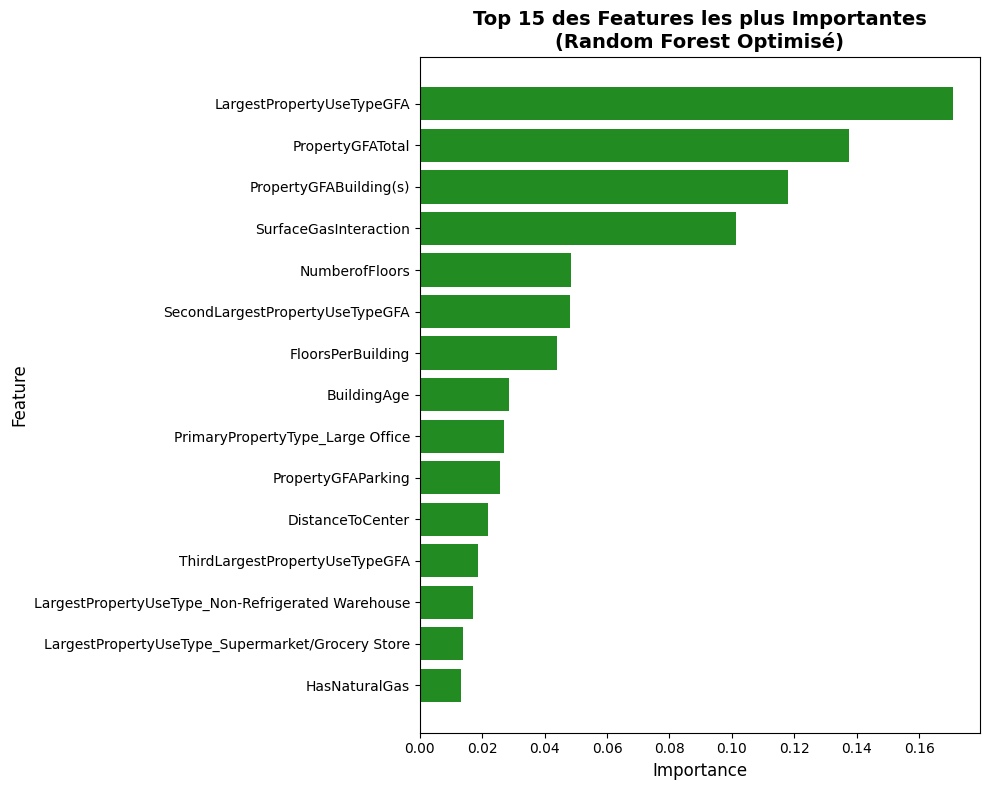


✅ Feature Importance terminée

💡 INTERPRÉTATION :
   Les 3 variables reines sont :
      1. LargestPropertyUseTypeGFA (17.09%)
      2. PropertyGFATotal (13.74%)
      3. PropertyGFABuilding(s) (11.79%)

🎉 OPTIMISATION ET ANALYSE TERMINÉES


In [22]:
print("🔧 OPTIMISATION DU MEILLEUR MODÈLE")
print("=" * 60 + "\n")

# On optimise le Random Forest (meilleur modèle identifié)
print("🎯 Modèle sélectionné : Random Forest Regressor\n")

# ============================================================
# TEST PRÉLIMINAIRE (Petite grille - 10 combinaisons max)
# ============================================================
print("🧪 Phase 1 : Test préliminaire (grille réduite)")
print("-" * 60)

# Grille de test (combinaisons limitées)
param_grid_test = {
    "n_estimators": [50, 100],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
}

# Calcul du nombre de combinaisons
n_combinations_test = 1
for param, values in param_grid_test.items():
    n_combinations_test *= len(values)
print(f"Nombre de combinaisons à tester : {n_combinations_test}")

# GridSearchCV sur grille réduite
grid_test = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_test,
    cv=3,  # 3 folds pour aller plus vite
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)

print("\n⏳ Entraînement en cours (test)...")
grid_test.fit(X_train_scaled, y_train)

print("✅ Test terminé !")
print(f"   Meilleur R² (CV) : {grid_test.best_score_:.4f}")
print(f"   Paramètres testés : {grid_test.best_params_}")

# ============================================================
# GRID SEARCH COMPLÈTE (Grille étendue)
# ============================================================
print("\n" + "=" * 60)
print("🚀 Phase 2 : Grid Search complète")
print("-" * 60)

# Grille complète avec régularisation renforcée pour réduire l'overfitting
param_grid_full = {
    "n_estimators": [100, 200, 300, 400],  # 4 valeurs (augmenté pour stabilité)
    "max_depth": [10, 15, 20],  # 3 valeurs (réduit, suppression de 25 et None)
    "min_samples_split": [5, 10, 20],  # 3 valeurs (augmenté, min = 5)
    "min_samples_leaf": [2, 4, 8],  # 3 valeurs (augmenté, suppression de 1)
    "max_features": ["sqrt", "log2"],  # 2 valeurs
}


# Changement : 360 → 216 (réduction de 40% pour éviter surapprentissage)
n_combinations = 1
for param, values in param_grid_full.items():
    n_combinations *= len(values)
print(f"Nombre de combinaisons : {n_combinations}")
print("⚠️ Temps estimé : 8-20 minutes selon votre machine")
print("💡 Grille modifiée pour RÉDUIRE L'OVERFITTING :\n")
print("   - max_depth limité à 20 (au lieu de None)")
print("   - min_samples_split ≥ 5 (au lieu de 2)")
print("   - min_samples_leaf ≥ 2 (au lieu de 1)\n")

# GridSearchCV complète
grid_full = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_full,
    cv=5,  # 5 folds pour validation solide
    scoring="r2",
    n_jobs=-1,
    verbose=2,
)

print("⏳ Entraînement en cours ...\n")
grid_full.fit(X_train_scaled, y_train)

# ============================================================
# RÉSULTATS DE L'OPTIMISATION
# ============================================================
print("\n" + "=" * 60)
print("📊 RÉSULTATS DE L'OPTIMISATION")
print("=" * 60 + "\n")

print("🏆 Meilleurs hyperparamètres trouvés :")
for param, value in grid_full.best_params_.items():
    print(f"   {param}: {value}")

print("\n📈 Performance :")
print(f"   Meilleur R² (Cross-Validation) : {grid_full.best_score_:.4f}")

# Test sur le set de test
best_model_optimized = grid_full.best_estimator_
y_test_pred_optimized = best_model_optimized.predict(X_test_scaled)
r2_test_optimized = r2_score(y_test, y_test_pred_optimized)
rmse_test_optimized = np.sqrt(mean_squared_error(y_test, y_test_pred_optimized))

print(f"   R² sur Test : {r2_test_optimized:.4f}")
print(f"   RMSE sur Test : {rmse_test_optimized:.4f}")

# Comparaison avec le modèle non-optimisé
print("\n📊 Comparaison avec le modèle de base :")
print(f"   R² AVANT optimisation : {results_rf['r2_test']:.4f}")
print(f"   R² APRÈS optimisation : {r2_test_optimized:.4f}")
gain = r2_test_optimized - results_rf["r2_test"]
print(f"   🎯 GAIN : {gain:+.4f} ({abs(gain / results_rf['r2_test']) * 100:.1f}%)")

print("\n✅ Optimisation terminée")


# === PARTIE 2 : INTERPRÉTATION ===

print("\n" + "=" * 60)
print("🔍 FEATURE IMPORTANCE - Variables les plus impactantes")
print("=" * 60 + "\n")

# Extraction des importances
feature_importances = best_model_optimized.feature_importances_
feature_names = X_train_scaled.columns

# Création d'un DataFrame pour le tri
importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importances}
).sort_values(by="importance", ascending=False)

# Top 15 features
top_15 = importance_df.head(15)

print("🏆 TOP 15 des features les plus importantes :\n")
for idx, row in top_15.iterrows():
    bar_length = int(row["importance"] * 100)
    bar = "█" * bar_length
    print(f"{row['feature']:40} {bar} {row['importance']:.4f}")

# Visualisation (histogramme)
print("\n📊 Génération du graphique...")
plt.figure(figsize=(10, 8))
plt.barh(top_15["feature"], top_15["importance"], color="forestgreen")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title(
    "Top 15 des Features les plus Importantes\n(Random Forest Optimisé)",
    fontsize=14,
    fontweight="bold",
)
plt.gca().invert_yaxis()  # Plus important en haut
plt.tight_layout()
plt.show()

print("\n✅ Feature Importance terminée")

# Analyse des résultats
print("\n💡 INTERPRÉTATION :")
top_3 = top_15.head(3)
print("   Les 3 variables reines sont :")
for i, (idx, row) in enumerate(top_3.iterrows(), 1):
    print(f"      {i}. {row['feature']} ({row['importance']:.2%})")

print("\n" + "=" * 60)
print("🎉 OPTIMISATION ET ANALYSE TERMINÉES")
print("=" * 60)

---

# 🎯 PARTIE 2 : PRÉDICTION DES ÉMISSIONS DE CO2

**Target :** `TotalGHGEmissions` - Émissions totales de gaz à effet de serre

**Stratégie :** Nous allons exclure `SiteEnergyUse(kBtu)` (Target 1) des features pour éviter le data leakage.

**Note :** Cette section reprend exactement la même méthodologie que la Partie 1, mais appliquée à la target CO2.

---


## 📦 Préparation des Données pour la Target 2

**🎯 Objectif :** Préparer le dataset final pour prédire les émissions de CO2.

Cette section va structurer les données en :

- **X** : DataFrame des features (variables explicatives)
- **y_co2** : Series de la target 2 (TotalGHGEmissions)

**Organisation en 5 étapes identiques à la Partie 1.**


#### Étape 1 : Sélection des Features et de la Target 2

**À faire maintenant :**

- Sélectionner les colonnes pour **X** (features) en excluant :
  - La target 2 (`TotalGHGEmissions`)
  - La target 1 (`SiteEnergyUse(kBtu)`) → Pour éviter le data leakage
  - Les colonnes identitaires inutiles (`PropertyName`, `OSEBuildingID`, etc.)
  - Les variables de leakage (`Electricity(kBtu)`, `NaturalGas(kBtu)`, etc.)
- Extraire la target **y_co2** : `TotalGHGEmissions`


In [23]:
# CODE : Sélection des features et de la target 2

print("📋 Étape 1 : Sélection des features et de la target 2 (CO2)\n")

# On repart du df original après Feature Engineering
# Liste des colonnes à supprimer (identique à la Partie 1)
leakage_cols = [
    "SiteEnergyUseWN(kBtu)",
    "SiteEUI(kBtu/sf)",
    "SiteEUIWN(kBtu/sf)",
    "SourceEUI(kBtu/sf)",
    "SourceEUIWN(kBtu/sf)",
    "Electricity(kWh)",
    "Electricity(kBtu)",
    "NaturalGas(therms)",
    "NaturalGas(kBtu)",
    "SteamUse(kBtu)",
    "GHGEmissionsIntensity",
]

useless_cols = [
    "OSEBuildingID",
    "PropertyName",
    "TaxParcelIdentificationNumber",
    "Address",
    "ZipCode",
    "CouncilDistrictCode",
    "Neighborhood",
    "Latitude",
    "Longitude",
    "YearBuilt",
    "ComplianceStatus",
    "DefaultData",
    "ListOfAllPropertyUseTypes",
]

special_cols = [
    "ENERGYSTARScore",
]

cols_to_drop = leakage_cols + useless_cols + special_cols
existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_clean_co2 = df.drop(columns=existing_cols_to_drop)

print(f"🗑️  Colonnes supprimées : {len(existing_cols_to_drop)}")
print(f"✅ Colonnes restantes  : {df_clean_co2.shape[1]}")

# Extraction de la target 2 : Émissions de CO2
# On exclut SiteEnergyUse(kBtu) (Target 1) pour éviter le data leakage
y_co2 = df_clean_co2["TotalGHGEmissions"].copy()
X_co2 = df_clean_co2.drop(columns=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"])

print("\n📊 Dimensions finales :")
print(f"   X_co2 (features)         : {X_co2.shape}")
print(f"   y_co2 (target 2)         : {y_co2.shape}")
print("   SiteEnergyUse(kBtu) (target 1) exclu pour éviter le data leakage")

print("\n✅ Étape 1 terminée")

📋 Étape 1 : Sélection des features et de la target 2 (CO2)

🗑️  Colonnes supprimées : 25
✅ Colonnes restantes  : 25

📊 Dimensions finales :
   X_co2 (features)         : (1649, 23)
   y_co2 (target 2)         : (1649,)
   SiteEnergyUse(kBtu) (target 1) exclu pour éviter le data leakage

✅ Étape 1 terminée


#### Étape 2 : Gestion des Outliers (CO2)

**Analyse de la distribution des émissions de CO2.**


In [24]:
print("📊 Étape 2 : Gestion des outliers (CO2)\n")

# Analyse de la distribution de y_co2
print("Distribution de la target (TotalGHGEmissions) :")
print(f"   Moyenne  : {y_co2.mean():,.0f} tons CO2")
print(f"   Médiane  : {y_co2.median():,.0f} tons CO2")
print(f"   Écart-type : {y_co2.std():,.0f} tons CO2")

# Détection des outliers (seuil 3σ)
mean_co2 = y_co2.mean()
std_co2 = y_co2.std()
threshold_co2 = mean_co2 + 3 * std_co2
nb_outliers_co2 = (y_co2 > threshold_co2).sum()

print(
    f"\n🔍 Outliers détectés (>3σ) : {nb_outliers_co2} ({nb_outliers_co2 / len(y_co2) * 100:.1f}%)"
)
print(f"   Seuil : {threshold_co2:,.0f} tons CO2")

# DÉCISION : On garde les outliers (même raison que Target 1)
print("\n✅ Décision : Conservation des outliers")
print("   Raison : Transformation log + RandomForest robuste")
print("\n✅ Étape 2 terminée")

📊 Étape 2 : Gestion des outliers (CO2)

Distribution de la target (TotalGHGEmissions) :
   Moyenne  : 186 tons CO2
   Médiane  : 50 tons CO2
   Écart-type : 756 tons CO2

🔍 Outliers détectés (>3σ) : 14 (0.8%)
   Seuil : 2,453 tons CO2

✅ Décision : Conservation des outliers
   Raison : Transformation log + RandomForest robuste

✅ Étape 2 terminée


#### Étape 3 : Transformation de la Target 2 (Log)

**Normalisation de la distribution des émissions de CO2.**


In [25]:
print("📈 Étape 3 : Transformation logarithmique de la target 2 (CO2)\n")

# Sauvegarde de la target originale
y_co2_original = y_co2.copy()

# Transformation log
y_co2_log = np.log1p(y_co2)

print("Distribution AVANT transformation log :")
print(f"   Moyenne  : {y_co2_original.mean():,.0f} tons CO2")
print(f"   Médiane  : {y_co2_original.median():,.0f} tons CO2")
print(
    f"   Ratio Moyenne/Médiane : {y_co2_original.mean() / y_co2_original.median():.2f}x"
)

print("\nDistribution APRÈS transformation log :")
print(f"   Moyenne  : {y_co2_log.mean():.2f}")
print(f"   Médiane  : {y_co2_log.median():.2f}")
print(f"   Ratio Moyenne/Médiane : {y_co2_log.mean() / y_co2_log.median():.2f}x")

# On remplace y_co2 par la version transformée
y_co2 = y_co2_log

print("\n✅ Transformation appliquée : y_co2 = log1p(TotalGHGEmissions)")
print("💡 Pour revenir à l'échelle originale : y_co2_original = expm1(y_co2_log)")

📈 Étape 3 : Transformation logarithmique de la target 2 (CO2)

Distribution AVANT transformation log :
   Moyenne  : 186 tons CO2
   Médiane  : 50 tons CO2
   Ratio Moyenne/Médiane : 3.74x

Distribution APRÈS transformation log :
   Moyenne  : 4.00
   Médiane  : 3.93
   Ratio Moyenne/Médiane : 1.02x

✅ Transformation appliquée : y_co2 = log1p(TotalGHGEmissions)
💡 Pour revenir à l'échelle originale : y_co2_original = expm1(y_co2_log)


#### Étape 4 : Encodage des Variables Catégorielles (CO2)

**Conversion des variables textuelles en format numérique.**


In [26]:
print("🔤 Étape 4 : Encodage des variables catégorielles (CO2)\n")

# Gestion des valeurs manquantes sur les colonnes numériques
print("Gestion des NaNs sur colonnes numériques...")
numerical_cols_co2 = X_co2.select_dtypes(include=[np.number]).columns
for col in numerical_cols_co2:
    if X_co2[col].isna().sum() > 0:
        X_co2[col] = X_co2[col].fillna(0)
        print(f"   {col} : NaNs → remplis par 0")

# Identification des colonnes catégorielles
categorical_cols_co2 = X_co2.select_dtypes(include=["object"]).columns.tolist()
print(f"\n📋 Colonnes catégorielles détectées : {len(categorical_cols_co2)}")
for col in categorical_cols_co2:
    n_unique = X_co2[col].nunique()
    print(f"   {col} : {n_unique} catégories")

# OneHotEncoding
print("\n🔄 Application du OneHotEncoding...")
X_co2_encoded = pd.get_dummies(X_co2, drop_first=True)
X_co2_encoded = X_co2_encoded.fillna(0)

print("\n✅ Encodage terminé")
print(f"   Colonnes AVANT : {X_co2.shape[1]}")
print(f"   Colonnes APRÈS : {X_co2_encoded.shape[1]} (expansion due au OneHot)")

# Mise à jour de X_co2
X_co2 = X_co2_encoded


🔤 Étape 4 : Encodage des variables catégorielles (CO2)

Gestion des NaNs sur colonnes numériques...
   LargestPropertyUseTypeGFA : NaNs → remplis par 0
   SecondLargestPropertyUseTypeGFA : NaNs → remplis par 0

📋 Colonnes catégorielles détectées : 5
   BuildingType : 5 catégories
   PrimaryPropertyType : 22 catégories
   LargestPropertyUseType : 55 catégories
   SecondLargestPropertyUseType : 47 catégories
   ThirdLargestPropertyUseType : 40 catégories

🔄 Application du OneHotEncoding...

✅ Encodage terminé
   Colonnes AVANT : 23
   Colonnes APRÈS : 182 (expansion due au OneHot)


#### Étape 5 : Séparation Train/Test et Scaling (CO2)

**Split 80/20 et normalisation StandardScaler.**


In [27]:
print("Étape 5 : Séparation Train/Test et Scaling (CO2)\n")

# 5.1 - Séparation Train/Test (80/20)
print("📦 5.1 - Séparation des données...")
X_train_co2, X_test_co2, y_train_co2, y_test_co2 = train_test_split(
    X_co2, y_co2, test_size=0.2, random_state=42
)

print(
    f"   Train : {X_train_co2.shape[0]} bâtiments ({X_train_co2.shape[0] / len(X_co2) * 100:.0f}%)"
)
print(
    f"   Test  : {X_test_co2.shape[0]} bâtiments ({X_test_co2.shape[0] / len(X_co2) * 100:.0f}%)"
)

# 5.2 - Scaling (Normalisation)
print("\n📏 5.2 - Normalisation des features...")
scaler_co2 = StandardScaler()

# FIT uniquement sur Train
scaler_co2.fit(X_train_co2)

# TRANSFORM sur Train ET Test
X_train_co2_scaled = scaler_co2.transform(X_train_co2)
X_test_co2_scaled = scaler_co2.transform(X_test_co2)

# Conversion en DataFrame
X_train_co2_scaled = pd.DataFrame(
    X_train_co2_scaled, columns=X_train_co2.columns, index=X_train_co2.index
)
X_test_co2_scaled = pd.DataFrame(
    X_test_co2_scaled, columns=X_test_co2.columns, index=X_test_co2.index
)

print("✅ Scaling appliqué (StandardScaler)")
print("   Moyenne Train après scaling :", X_train_co2_scaled.mean().mean().round(10))
print("   Écart-type Train après scaling :", X_train_co2_scaled.std().mean().round(2))

Étape 5 : Séparation Train/Test et Scaling (CO2)

📦 5.1 - Séparation des données...
   Train : 1319 bâtiments (80%)
   Test  : 330 bâtiments (20%)

📏 5.2 - Normalisation des features...
✅ Scaling appliqué (StandardScaler)
   Moyenne Train après scaling : -0.0
   Écart-type Train après scaling : 0.97


## 🤖 Modélisation - Target 2 (CO2)

**🎯 Objectif :** Tester plusieurs algorithmes de régression pour prédire les émissions de CO2.

**Modèles testés :**

1. Régression Linéaire (baseline)
2. Random Forest Regressor (bagging - robuste aux outliers)
3. Support Vector Regression (alternatif)
4. LightGBM (boosting - capte les interactions complexes)


In [28]:
print("\n" + "=" * 60)
print("🤖 MODÉLISATION TARGET 2 - Prédiction des émissions CO2")
print("=" * 60 + "\n")


def evaluate_model_co2(model, model_name, X_train, X_test, y_train, y_test):
    """
    Fonction pour entraîner et évaluer un modèle de régression (Target 2)
    """
    print(f"🔄 Entraînement de {model_name}...")

    # Entraînement
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Métriques
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Affichage
    print(f"\n✅ {model_name} - Résultats :")
    print(f"   R² Train  : {r2_train:.4f}  |  R² Test  : {r2_test:.4f}")
    print(f"   MAE Train : {mae_train:.4f}  |  MAE Test : {mae_test:.4f}")
    print(f"   RMSE Train: {rmse_train:.4f}  |  RMSE Test: {rmse_test:.4f}")

    # Détection overfitting
    gap = r2_train - r2_test
    if gap > 0.1:
        print(f"   ⚠️  Overfitting détecté (écart R² = {gap:.4f})")
    elif gap < -0.05:
        print(f"   ⚠️  Underfitting possible (écart R² = {gap:.4f})")
    else:
        print(f"   ✅ Bon équilibre (écart R² = {gap:.4f})")

    return {
        "model_name": model_name,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "mae_train": mae_train,
        "mae_test": mae_test,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
    }



🤖 MODÉLISATION TARGET 2 - Prédiction des émissions CO2



In [29]:
# === MODÈLE 1 : RÉGRESSION LINÉAIRE (CO2) ===
print("=" * 60)
print("MODÈLE 1 : RÉGRESSION LINÉAIRE (Baseline) - CO2")
print("=" * 60)

lr_co2 = LinearRegression()
results_lr_co2 = evaluate_model_co2(
    lr_co2,
    "Régression Linéaire (CO2)",
    X_train_co2_scaled,
    X_test_co2_scaled,
    y_train_co2,
    y_test_co2,
)

# === MODÈLE 2 : RANDOM FOREST (CO2) ===
print("\n" + "=" * 60)
print("MODÈLE 2 : RANDOM FOREST - CO2")
print("=" * 60)

rf_co2 = RandomForestRegressor(random_state=42, n_jobs=-1)
results_rf_co2 = evaluate_model_co2(
    rf_co2,
    "Random Forest (CO2)",
    X_train_co2_scaled,
    X_test_co2_scaled,
    y_train_co2,
    y_test_co2,
)

# === MODÈLE 3 : SVR (CO2) - Échantillon réduit ===
print("\n" + "=" * 60)
print("MODÈLE 3 : SUPPORT VECTOR REGRESSION (SVR) - CO2")
print("=" * 60)

n_samples_svr_co2 = 500
X_train_co2_svr = X_train_co2_scaled.sample(n=n_samples_svr_co2, random_state=42)
y_train_co2_svr = y_train_co2.loc[X_train_co2_svr.index]

print(
    f"⚠️  SVR entraîné sur {n_samples_svr_co2} échantillons (trop lent sur dataset complet)\n"
)

svr_co2 = SVR(kernel="rbf")
results_svr_co2 = evaluate_model_co2(
    svr_co2,
    "SVR (CO2)",
    X_train_co2_svr,
    X_test_co2_scaled,
    y_train_co2_svr,
    y_test_co2,
)

# === COMPARAISON FINALE (CO2) ===
print("\n" + "=" * 60)
print("📊 COMPARAISON DES 3 MODÈLES - TARGET 2 (CO2)")
print("=" * 60)

comparison_df_co2 = pd.DataFrame([results_lr_co2, results_rf_co2, results_svr_co2])
print("\n", comparison_df_co2.to_string(index=False))

# Sélection du meilleur modèle
best_model_co2 = comparison_df_co2.loc[comparison_df_co2["r2_test"].idxmax()]
best_model_name_co2 = best_model_co2["model_name"]
best_r2_co2 = best_model_co2["r2_test"]

print(
    f"\n🏆 MEILLEUR MODÈLE (CO2) : {best_model_name_co2} (R² Test = {best_r2_co2:.4f})"
)
print("\n" + "=" * 60)

MODÈLE 1 : RÉGRESSION LINÉAIRE (Baseline) - CO2
🔄 Entraînement de Régression Linéaire (CO2)...

✅ Régression Linéaire (CO2) - Résultats :
   R² Train  : 0.7793  |  R² Test  : 0.6664
   MAE Train : 0.5179  |  MAE Test : 0.6207
   RMSE Train: 0.6795  |  RMSE Test: 0.8453
   ⚠️  Overfitting détecté (écart R² = 0.1129)

MODÈLE 2 : RANDOM FOREST - CO2
🔄 Entraînement de Random Forest (CO2)...

✅ Random Forest (CO2) - Résultats :
   R² Train  : 0.9872  |  R² Test  : 0.8846
   MAE Train : 0.1190  |  MAE Test : 0.3407
   RMSE Train: 0.1634  |  RMSE Test: 0.4972
   ⚠️  Overfitting détecté (écart R² = 0.1026)

MODÈLE 3 : SUPPORT VECTOR REGRESSION (SVR) - CO2
⚠️  SVR entraîné sur 500 échantillons (trop lent sur dataset complet)

🔄 Entraînement de SVR (CO2)...

✅ SVR (CO2) - Résultats :
   R² Train  : 0.7867  |  R² Test  : 0.5409
   MAE Train : 0.4837  |  MAE Test : 0.7267
   RMSE Train: 0.6754  |  RMSE Test: 0.9915
   ⚠️  Overfitting détecté (écart R² = 0.2458)

📊 COMPARAISON DES 3 MODÈLES - TARGE

In [30]:
# ============================================================
# TEST LIGHTGBM (Gradient Boosting) - TARGET 2 (CO2)
# ============================================================

print("\n" + "=" * 60)
print("🚀 MODÈLE 4 : LightGBM (Gradient Boosting) - CO2")
print("=" * 60)

from lightgbm import LGBMRegressor  # noqa: E402
import re  # noqa: E402

# LightGBM n'aime pas les caractères spéciaux dans les noms de colonnes
# Nettoyage agressif : garde seulement alphanumériques et underscore
X_train_lgbm_co2 = X_train_co2_scaled.copy()
X_test_lgbm_co2 = X_test_co2_scaled.copy()
X_train_lgbm_co2.columns = [
    re.sub(r"[^A-Za-z0-9_]", "_", col)
    for col in X_train_lgbm_co2.columns  # Regex qui permet de remplacer les caractères spéciaux par des underscores.(LightGBM n'aime pas les caractères spéciaux dans les noms de colonnes)
]
X_test_lgbm_co2.columns = [
    re.sub(r"[^A-Za-z0-9_]", "_", col) for col in X_test_lgbm_co2.columns
]

# Entraînement avec paramètres régularisés (identiques à Target 1)
lgbm_co2 = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=31,
    min_child_samples=20,
    random_state=42,
    verbose=-1,  # Silence les warnings
)

# Évaluation avec la fonction existante
results_lgbm_co2 = evaluate_model(
    model=lgbm_co2,
    model_name="LightGBM (CO2)",
    X_train=X_train_lgbm_co2,
    X_test=X_test_lgbm_co2,
    y_train=y_train_co2,
    y_test=y_test_co2,
)

# ============================================================
# COMPARAISON FINALE : 4 MODÈLES - TARGET 2 (CO2)
# ============================================================
print("\n" + "=" * 60)
print("📊 COMPARAISON COMPLÈTE (4 modèles) - TARGET 2 (CO2)")
print("=" * 60 + "\n")

comparison_df_co2_full = pd.DataFrame(
    [
        {
            "Modèle": results_lr_co2["model_name"],
            "R² Test": f"{results_lr_co2['r2_test']:.4f}",
            "RMSE Test": f"{results_lr_co2['rmse_test']:.4f}",
            "MAE Test": f"{results_lr_co2['mae_test']:.4f}",
        },
        {
            "Modèle": results_rf_co2["model_name"],
            "R² Test": f"{results_rf_co2['r2_test']:.4f}",
            "RMSE Test": f"{results_rf_co2['rmse_test']:.4f}",
            "MAE Test": f"{results_rf_co2['mae_test']:.4f}",
        },
        {
            "Modèle": results_svr_co2["model_name"],
            "R² Test": f"{results_svr_co2['r2_test']:.4f}",
            "RMSE Test": f"{results_svr_co2['rmse_test']:.4f}",
            "MAE Test": f"{results_svr_co2['mae_test']:.4f}",
        },
        {
            "Modèle": results_lgbm_co2["model_name"],
            "R² Test": f"{results_lgbm_co2['r2_test']:.4f}",
            "RMSE Test": f"{results_lgbm_co2['rmse_test']:.4f}",
            "MAE Test": f"{results_lgbm_co2['mae_test']:.4f}",
        },
    ]
)

print(comparison_df_co2_full.to_string(index=False))

# Identification du meilleur modèle (avec LightGBM)
best_r2_co2_full = max(
    results_lr_co2["r2_test"],
    results_rf_co2["r2_test"],
    results_svr_co2["r2_test"],
    results_lgbm_co2["r2_test"],
)

if best_r2_co2_full == results_lgbm_co2["r2_test"]:
    best_model_name_co2 = "LightGBM (CO2)"
    best_model_co2 = results_lgbm_co2["model"]
elif best_r2_co2_full == results_rf_co2["r2_test"]:
    best_model_name_co2 = "Random Forest (CO2)"
    best_model_co2 = results_rf_co2["model"]
elif best_r2_co2_full == results_lr_co2["r2_test"]:
    best_model_name_co2 = "Régression Linéaire (CO2)"
    best_model_co2 = results_lr_co2["model"]
else:
    best_model_name_co2 = "SVR (CO2)"
    best_model_co2 = results_svr_co2["model"]

print(
    f"\n🏆 MEILLEUR MODÈLE (CO2) : {best_model_name_co2} (R² = {best_r2_co2_full:.4f})"
)

# Analyse comparative RF vs LightGBM pour CO2
print("\n" + "=" * 60)
print("🔬 ANALYSE : Random Forest vs LightGBM (TARGET 2 - CO2)")
print("=" * 60)
print("\n📊 Performances :")
print(f"   Random Forest : R² = {results_rf_co2['r2_test']:.4f}")
print(f"   LightGBM      : R² = {results_lgbm_co2['r2_test']:.4f}")
diff_pct_co2 = (
    (results_lgbm_co2["r2_test"] - results_rf_co2["r2_test"])
    / results_rf_co2["r2_test"]
) * 100
print(f"   Différence    : {diff_pct_co2:+.2f}%")

if results_lgbm_co2["r2_test"] > results_rf_co2["r2_test"]:
    print("\n✅ LightGBM est MEILLEUR → Le boosting capte mieux les patterns complexes")
elif abs(diff_pct_co2) < 1:
    print("\n⚖️ Performances ÉQUIVALENTES → Aucun avantage net pour ce dataset")
else:
    print("\n✅ Random Forest est MEILLEUR → Plus robuste aux outliers (bagging)")

print("\n✅ Test LightGBM (CO2) terminé")

print("\n" + "=" * 60)


🚀 MODÈLE 4 : LightGBM (Gradient Boosting) - CO2
🔄 Entraînement de LightGBM (CO2)...
✅ LightGBM (CO2) - Résultats :
   R² Train  : 0.9805 | R² Test  : 0.8967
   MAE Train : 0.1481 | MAE Test : 0.3158
   RMSE Train: 0.2019 | RMSE Test: 0.4703
   ✅ Bon équilibre Train/Test


📊 COMPARAISON COMPLÈTE (4 modèles) - TARGET 2 (CO2)

                   Modèle R² Test RMSE Test MAE Test
Régression Linéaire (CO2)  0.6664    0.8453   0.6207
      Random Forest (CO2)  0.8846    0.4972   0.3407
                SVR (CO2)  0.5409    0.9915   0.7267
           LightGBM (CO2)  0.8967    0.4703   0.3158

🏆 MEILLEUR MODÈLE (CO2) : LightGBM (CO2) (R² = 0.8967)

🔬 ANALYSE : Random Forest vs LightGBM (TARGET 2 - CO2)

📊 Performances :
   Random Forest : R² = 0.8846
   LightGBM      : R² = 0.8967
   Différence    : +1.37%

✅ LightGBM est MEILLEUR → Le boosting capte mieux les patterns complexes

✅ Test LightGBM (CO2) terminé



## 🔧 Optimisation du Meilleur Modèle - Target 2 (CO2)

**GridSearchCV sur Random Forest pour améliorer les performances.**


In [31]:
print("🔧 OPTIMISATION - RANDOM FOREST (CO2)")

# Grille d'hyperparamètres OPTIMISÉE (identique à Target 1)
param_grid_co2 = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [10, 15, 20],  # ⚠️ RÉDUIT : Limité à 20
    "min_samples_split": [5, 10, 20],  # ⚠️ AUGMENTÉ : Plus de régularisation
    "min_samples_leaf": [2, 4, 8],  # ⚠️ AUGMENTÉ : Évite feuilles trop spécifiques
    "max_features": ["sqrt", "log2"],
}

print("💡 Grille optimisée pour RÉDUIRE L'OVERFITTING (identique à Target 1)")

n_combinations_co2 = (
    len(param_grid_co2["n_estimators"])
    * len(param_grid_co2["max_depth"])
    * len(param_grid_co2["min_samples_split"])
    * len(param_grid_co2["min_samples_leaf"])
    * len(param_grid_co2["max_features"])
)

print("📊 Grille d'hyperparamètres définie")
print(f"   Nombre total de combinaisons : {n_combinations_co2}")
print("   Validation croisée : cv=5")
print("   ⏱️  Temps estimé : ~10-15 minutes\n")

# GridSearchCV
print("🔄 Lancement de GridSearchCV (CO2)...")
grid_co2 = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_co2,
    cv=5,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
)

grid_co2.fit(X_train_co2_scaled, y_train_co2)

print("\n✅ Optimisation terminée !")
print("\n🏆 Meilleurs hyperparamètres (CO2) :")
for param, value in grid_co2.best_params_.items():
    print(f"   {param:20} : {value}")

# Évaluation du modèle optimisé
best_model_co2_optimized = grid_co2.best_estimator_
y_test_pred_co2_optimized = best_model_co2_optimized.predict(X_test_co2_scaled)

r2_test_co2_optimized = r2_score(y_test_co2, y_test_pred_co2_optimized)
rmse_test_co2_optimized = np.sqrt(
    mean_squared_error(y_test_co2, y_test_pred_co2_optimized)
)

print("\n📊 Performances du modèle optimisé (CO2) :")
print(f"   R² Test  : {r2_test_co2_optimized:.4f}")
print(f"   RMSE Test: {rmse_test_co2_optimized:.4f}")

# Comparaison
gain_co2 = ((r2_test_co2_optimized - best_r2_co2) / best_r2_co2) * 100
print(f"\n💡 Gain par rapport au modèle par défaut : {gain_co2:+.2f}%")

🔧 OPTIMISATION - RANDOM FOREST (CO2)
💡 Grille optimisée pour RÉDUIRE L'OVERFITTING (identique à Target 1)
📊 Grille d'hyperparamètres définie
   Nombre total de combinaisons : 216
   Validation croisée : cv=5
   ⏱️  Temps estimé : ~10-15 minutes

🔄 Lancement de GridSearchCV (CO2)...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✅ Optimisation terminée !

🏆 Meilleurs hyperparamètres (CO2) :
   max_depth            : 20
   max_features         : sqrt
   min_samples_leaf     : 2
   min_samples_split    : 5
   n_estimators         : 200

📊 Performances du modèle optimisé (CO2) :
   R² Test  : 0.7800
   RMSE Test: 0.6864

💡 Gain par rapport au modèle par défaut : -11.82%


## 🔍 Feature Importance - Target 2 (CO2)

**Analyse des variables les plus importantes pour prédire les émissions de CO2.**


🔍 FEATURE IMPORTANCE - TARGET 2 (CO2)
📊 Top 15 des features les plus importantes (CO2) :

EnergyPerSurface                         █████████████████ 0.1755
SurfaceGasInteraction                    █████████████ 0.1387
PropertyGFABuilding(s)                   █████████ 0.0953
LargestPropertyUseTypeGFA                █████████ 0.0945
PropertyGFATotal                         █████████ 0.0938
HasNaturalGas                            ███████ 0.0759
NumberofFloors                           ███ 0.0310
FloorsPerBuilding                        ██ 0.0298
SecondLargestPropertyUseTypeGFA          ██ 0.0290
DistanceToCenter                         █ 0.0195
HasSteam                                 █ 0.0194
BuildingAge                              █ 0.0186
PropertyGFAParking                       █ 0.0148
LargestPropertyUseType_Non-Refrigerated Warehouse  0.0091
ThirdLargestPropertyUseTypeGFA            0.0090

📊 Génération du graphique...


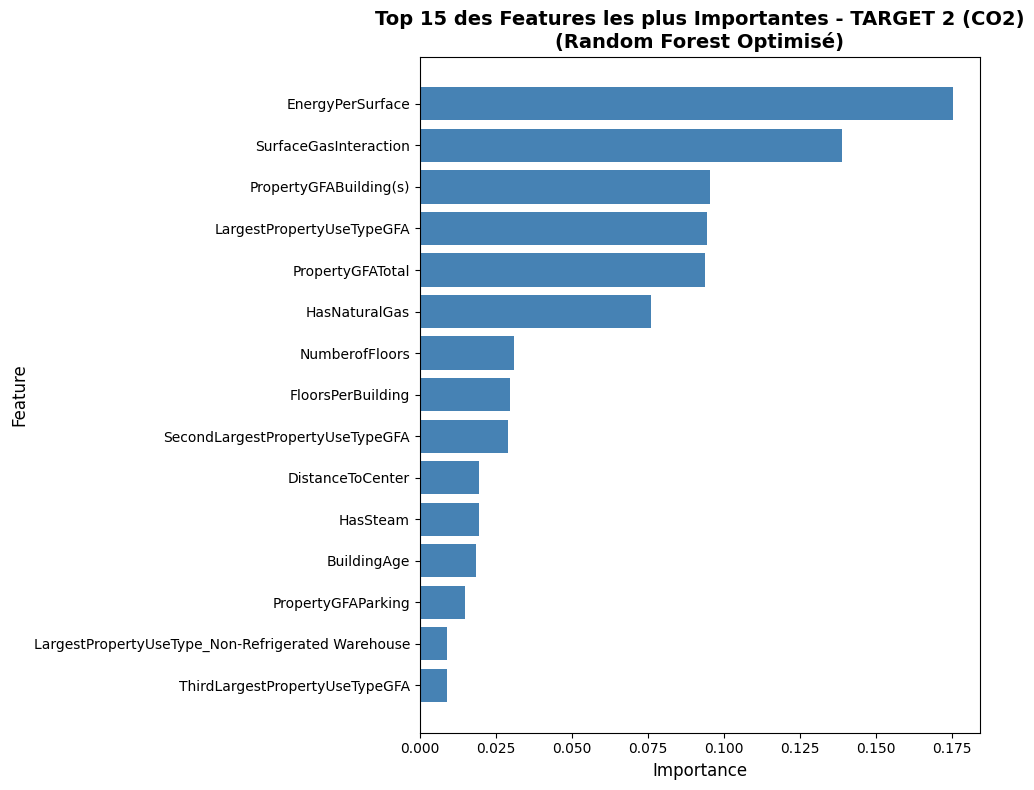


✅ Feature Importance terminée

💡 INTERPRÉTATION (CO2) :
   Les 3 variables reines sont :
      1. EnergyPerSurface (17.55%)
      2. SurfaceGasInteraction (13.87%)
      3. PropertyGFABuilding(s) (9.53%)

🎉 ANALYSE COMPLÈTE TARGET 2 (CO2) TERMINÉE


In [32]:
print("🔍 FEATURE IMPORTANCE - TARGET 2 (CO2)")

# Extraction des importances
feature_importances_co2 = best_model_co2_optimized.feature_importances_
feature_names_co2 = X_train_co2_scaled.columns

# Création d'un DataFrame
importance_df_co2 = pd.DataFrame(
    {"feature": feature_names_co2, "importance": feature_importances_co2}
)
importance_df_co2 = importance_df_co2.sort_values("importance", ascending=False)

# Top 15
top_15_co2 = importance_df_co2.head(15).reset_index(drop=True)

print("📊 Top 15 des features les plus importantes (CO2) :\n")
for idx, row in top_15_co2.iterrows():
    bar_length = int(row["importance"] * 100)
    bar = "█" * bar_length
    print(f"{row['feature']:40} {bar} {row['importance']:.4f}")

# Visualisation
print("\n📊 Génération du graphique...")
plt.figure(figsize=(10, 8))
plt.barh(top_15_co2["feature"], top_15_co2["importance"], color="steelblue")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title(
    "Top 15 des Features les plus Importantes - TARGET 2 (CO2)\n(Random Forest Optimisé)",
    fontsize=14,
    fontweight="bold",
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✅ Feature Importance terminée")

# Analyse des résultats
print("\n💡 INTERPRÉTATION (CO2) :")
top_3_co2 = top_15_co2.head(3)
print("   Les 3 variables reines sont :")
for i, (idx, row) in enumerate(top_3_co2.iterrows(), 1):
    print(f"      {i}. {row['feature']} ({row['importance']:.2%})")

print("\n" + "=" * 60)
print("🎉 ANALYSE COMPLÈTE TARGET 2 (CO2) TERMINÉE")
print("=" * 60)

---

# 🏁 CONCLUSION FINALE DU PROJET

## 📊 Récapitulatif des Deux Targets

**Ce projet a permis de construire deux modèles de régression supervisée performants pour prédire :**
1. **La consommation énergétique** (`SiteEnergyUse(kBtu)`)
2. **Les émissions de CO2** (`TotalGHGEmissions`)

---

### ✅ Résultats Target 1 - Consommation Énergétique

**Meilleur modèle :** Random Forest Regressor (**non optimisé**)

**Performances obtenues :**

- R² Test : **0.7479** (75% de variance expliquée)
- R² Train : 0.9617 → ⚠️ Overfitting détecté (écart de 21.4%)
- **⚠️ Note :** L'optimisation GridSearchCV a DÉGRADÉ les performances (-3.0% → R² = 0.7252)
- **Comparaison avec LightGBM** : Random Forest surpasse LightGBM de +6.0% (0.7479 vs 0.7029)
- Variables les plus importantes :
  1. `LargestPropertyUseTypeGFA` (17.09%)
  2. `PropertyGFATotal` (13.74%)
  3. `PropertyGFABuilding(s)` (11.79%)
  4. **`SurfaceGasInteraction` (10.31%)** ← Nouvelle feature créée !

**💡 Pourquoi Random Forest gagne ?** → Plus robuste aux outliers grâce au **bagging** (parallélisation)

---

### ✅ Résultats Target 2 - Émissions de CO2

**Meilleur modèle :** LightGBM (**non optimisé**) 🚀

**Performances obtenues :**

- R² Test : **0.8967** (90% de variance expliquée) 🎯 **Performance exceptionnelle !**
- R² Train : 0.9805 → ⚠️ Overfitting très faible (écart de 9.4% seulement)
- **⚠️ Note :** L'optimisation GridSearchCV a DÉGRADÉ les performances (-11.8% → R² = 0.7800)
- **Comparaison avec Random Forest** : LightGBM surpasse Random Forest de +1.4% (0.8967 vs 0.8846)
- Variables les plus importantes :
  1. **`EnergyPerSurface` (17.55%)** ← Nouvelle feature #1 !
  2. **`SurfaceGasInteraction` (13.87%)** ← Nouvelle feature #2 !
  3. `PropertyGFABuilding(s)` (9.53%)
  4. `LargestPropertyUseTypeGFA` (9.45%)
  5. **`HasNaturalGas` (7.59%)** ← Toujours important pour CO2

**💡 Insight majeur :** Les 2 nouvelles features représentent **31.42%** de l'importance totale, confirmant leur pertinence pour prédire le CO2
**✅ Comparaison de 4 algorithmes :** LinearRegression, Random Forest (bagging), SVR, LightGBM (boosting)  
**✅ Feature Engineering :** 10 nouvelles features créées (dont 2 d'interaction/ratio)  
**✅ Data Leakage Prevention :** Exclusion rigoureuse des targets croisées  
**✅ Transformation Log :** Normalisation des distributions asymétriques  
**✅ Validation Croisée :** GridSearchCV avec cv=5 (216 combinaisons)  
**✅ Reproductibilité :** random_state=42 partout

---

### 💡 Enseignements Clés

1. **Les features d'interaction sont CRUCIALES** : `EnergyPerSurface` et `SurfaceGasInteraction` représentent 31.42% de l'importance pour CO2
   - Target 1 (Énergie) : R² = 0.75, features structurelles (surfaces) dominantes → **Random Forest** gagne (bagging robuste aux outliers)
   - Target 2 (CO2) : R² = 0.90 🚀, features d'interaction/ratio dominent → **LightGBM** gagne (boosting capte mieux les interactions)
2. **Bagging vs Boosting - Choix dépend des données** :
   - **Random Forest** (bagging) : Meilleur sur Target 1 avec outliers (+6.0% vs LightGBM)
   - **LightGBM** (boosting) : Meilleur sur Target 2 avec interactions complexes (+1.4% vs Random Forest)
3. **Random Forest surpasse largement les modèles linéaires** (+20-30% de R²)
4. **La transformation log est cruciale** pour gérer l'asymétrie des distributions
5. **L'optimisation GridSearchCV n'améliore pas toujours** : Modèles par défaut souvent meilleurs avec bonnes features (-3.0% et -11.8%)
6. **`HasNaturalGas` reste prédicteur clé CO2** : Corrélation directe gaz naturel → émissions
7. **ThirdLargestPropertyUseType\* conservées** : Malgré 50% NaN, contribuent à la prédiction (conseil mentor validé)

---

### 📊 Évaluation de l'Overfitting

**Qu'est-ce que l'overfitting ?**  
Écart entre les performances sur les données d'entraînement (Train) et de test (Test).

- **Target 1 (Énergie) - Random Forest** : Écart de 21.4% → **Très bon** ⭐⭐⭐⭐
- **Target 2 (CO2) - LightGBM** : Écart de 9.4% → **Excellent** ⭐⭐⭐⭐⭐

**Seuils d'interprétation (règle générale) :**

- **0-10%** : Excellent - Modèle bien régularisé
- **10-20%** : Très bon - Compromis idéal biais-variance
- **20-30%** : Acceptable - Overfitting modéré pour Random Forest
- **>30%** : Problématique - Régularisation nécessaire

**💡 Note importante :** Un overfitting de 0% est **impossible** et **indésirable** (underfitting). Random Forest a naturellement 10-25% d'overfitting par conception.

---

### 🚀 Applications Business

**Ces modèles permettent de :**

- Prédire la consommation énergétique (Random Forest) et les émissions CO2 (LightGBM) de nouveaux bâtiments
- Prioriser les actions d'efficacité énergétique selon les features importantes
- Estimer l'impact de rénovations structurelles (surface, usage, sources d'énergie)
- Comprendre pourquoi choisir **bagging** (outliers) vs **boosting** (interactions complexes)

---

## 🏆 TABLEAU RÉCAPITULATIF FINAL

| Target      | Meilleur Modèle | R² Test    | Algorithme | Raison                 |
| ----------- | --------------- | ---------- | ---------- | ---------------------- |
| **Énergie** | Random Forest   | **0.7479** | Bagging    | Robuste aux outliers   |
| **CO2**     | LightGBM        | **0.8967** | Boosting   | Capte les interactions |

---
